<img src="../images/unification.png" alt="Unification, Fig. 6" width="85%"/>

---

This notebook presents the results of the paper (Table 4) and showcases automatically discovered and proven mathematical formula equivalences (stored in the coboundary graph).  
The [results colab](https://colab.research.google.com/drive/13EC9hwEhoA_xvEu_7p_9wbIl2QjDknqC?usp=sharing) complements with specific examples.

Please create and activate a new virtual environment and then install our *unifier* package to proceed.

After installing the unifier package:   
- Scroll down to recreate Table 4 from the coboundary graph.  
- [View the coboundary graph](##visualize-the-unified-components-of-the-coboundary-graph).
---

In [1]:
import pickle
import sympy as sp
import networkx as nx
import matplotlib.pyplot as plt
import random
from IPython.display import display

from unifier import PCF

n = sp.symbols('n')

In [2]:
PCFS = "../dataset/pcfs.pkl"          # formulas in canonical form
CMFPCFS = "../dataset/cmf_pcfs.pkl"   # cmf representatives for unification
GRAPH = "coboundary_graph.pkl"  # resulting coboundary graph

with open(PCFS, "rb") as f:
    pcfs = pickle.load(f)

with open(CMFPCFS, "rb") as f:
    cmf_pcfs = pickle.load(f)

with open(GRAPH, "rb") as f:
    graph = pickle.load(f)

A look at the formulas:

In [3]:
pcfs.head(3)

,ab,a,b,limit,sources,delta,convergence_rate
0,"(2, n**2)",2,n**2,2/(4 - pi),"[{'type': 'cf', 'formula': 'PCF(2 , n**2)', 'f...",-0.99791,0.00294
1,"(1, n**2 + n)",1,n**2 + n,2/(pi - 2),"[{'type': 'cf', 'formula': 'PCF(1, n**2 + n)',...",-0.99915,0.00140
2,"(4, 4*n**2 - 1)",4,4*n**2 - 1,(2 + pi)/(-2 + pi),"[{'type': 'cf', 'formula': 'PCF(4 , 4*n**2 - 1...",-0.99867,0.00288


Preprocess the graph to remove unsuccessful edges:

In [4]:
def remove_unsuccessful_edges(graph):

    """
    Remove edges from the graph that do not have a successful transformation.
    Such "attempted edges" were kept for internal use.
    """
    
    edges_to_remove = []
    for u, v, data in graph.edges(data=True):
        if data.get('transformation') is None:
            edges_to_remove.append((u, v))
    
    for edge in edges_to_remove:
        graph.remove_edge(*edge)
    
    return graph

In [5]:
graph = remove_unsuccessful_edges(graph)
print('Numer of edges:', len(graph.edges))

Numer of edges: 121


Before going into numbers, let's see a random example for an equivalence found by the algorithm.  
  
These transformations are of the form:  
Fold1 ( formula1 ) * U( n + 1 ) == U( n ) * Fold2 ( formula2 )  
where both formulas are represented by their recurrences.  

This can also be written as  
U( n )^( -1 ) * Fold1 ( formula1 ) * U( n + 1 ) == Fold2 ( formula2 )  
or  
Coboundary( Fold1 ( formula1 ) ) == Fold2 ( formula2 )  
which is the format adopted in our package

In [6]:
def check_edge(graph, node1, node2, verbose=False):
    """
    Applies the transformation between two formulas in canonical form (nodes) in the graph.
    Raises an error if the edge does not exist.
    """

    assert node1 in graph.nodes, f"Node1 not in graph: {node1}"
    assert node2 in graph.nodes, f"Node2 not in graph: {node2}"
    assert graph.has_edge(node1, node2), f"Edge not found: {node1} -> {node2}"

    node1_data = graph.nodes[node1]
    pcf1 = PCF(sp.sympify(node1_data['a']), sp.sympify(node1_data['b']))
    
    node2_data = graph.nodes[node2]
    pcf2 = PCF(sp.sympify(node2_data['a']), sp.sympify(node2_data['b']))

    transformation = graph.edges[node1, node2]['transformation']
    if transformation is None:
        assert False, f"Transformation not found for edge {node1} -> {node2}"
    fold1, fold2, coboundary = transformation

    folded1 = fold1(pcf1.CM())
    coboundary_folded1 = coboundary(folded1)
    folded2 = fold2(pcf2.CM())

    truth = sp.simplify(coboundary_folded1 - folded2) == sp.zeros(2, 2)

    if verbose:
        print(f"Checking edge {node1} -> {node2}")
        
        print(f"PCF1:\n {pcf1}")
        print(f"PCF2:\n {pcf2}")
        print(f"Fold1 transform:\n {fold1}")
        print(f"Fold2 transform:\n {fold2}")
        print(f"Coboundary transform:\n {coboundary}")

        print("\nFold1 ( PCF1 ):\n")
        display(folded1)
        print("Coboundary ( Fold1 ( PCF1 ) ):\n")
        display(coboundary_folded1)
        print("==?==")
        print("Fold2 ( PCF2 ):\n")
        display(folded2)

        print("Success:\n", truth)
    
    return truth

In [7]:
edges_to_check = random.sample(list(graph.edges), 1)

for edge in edges_to_check:
    truth = check_edge(graph, edge[0], edge[1], verbose=True)
    if truth:
        print("Check passed!\n\n")
    else:
        print("Check failed!\n\n")

Checking edge ('21840*n**4 + 67952*n**3 + 73008*n**2 + 29508*n + 2607', '-7225344*n**8 - 12558336*n**7 - 876544*n**6 + 8491008*n**5 + 5127168*n**4 + 890368*n**3') -> ('21840*n**5 + 63120*n**4 + 58976*n**3 + 15348*n**2 - 2925*n - 550', '-7225344*n**10 + 11870208*n**9 + 7790592*n**8 - 21516288*n**7 + 5676032*n**6 + 7635456*n**5 - 5004288*n**4 + 856064*n**3')
PCF1:
 PCF(21840*n**4 + 67952*n**3 + 73008*n**2 + 29508*n + 2607 , n**3*(-7225344*n**5 - 12558336*n**4 - 876544*n**3 + 8491008*n**2 + 5127168*n + 890368))
PCF2:
 PCF(21840*n**5 + 63120*n**4 + 58976*n**3 + 15348*n**2 - 2925*n - 550 , n**3*(-7225344*n**7 + 11870208*n**6 + 7790592*n**5 - 21516288*n**4 + 5676032*n**3 + 7635456*n**2 - 5004288*n + 856064))
Fold1 transform:
 FoldToPCF(transforms : Fold(factor : 1) , AsPCF(U : Matrix([[1, 0], [0, 1]]), multiplier : 1))
Fold2 transform:
 FoldToPCF(transforms : Fold(factor : 1) , AsPCF(U : Matrix([[1, 0], [0, 1]]), multiplier : 1))
Coboundary transform:
 CobTransform(U : Matrix([[6048*n**5 - 1

Matrix([
[0, n**3*(-7225344*n**5 - 12558336*n**4 - 876544*n**3 + 8491008*n**2 + 5127168*n + 890368)],
[1,                                  21840*n**4 + 67952*n**3 + 73008*n**2 + 29508*n + 2607]])

Coboundary ( Fold1 ( PCF1 ) ):



Matrix([
[0, n**3*(-7225344*n**7 + 11870208*n**6 + 7790592*n**5 - 21516288*n**4 + 5676032*n**3 + 7635456*n**2 - 5004288*n + 856064)],
[1,                                                       21840*n**5 + 63120*n**4 + 58976*n**3 + 15348*n**2 - 2925*n - 550]])

==?==
Fold2 ( PCF2 ):



Matrix([
[0, n**3*(-7225344*n**7 + 11870208*n**6 + 7790592*n**5 - 21516288*n**4 + 5676032*n**3 + 7635456*n**2 - 5004288*n + 856064)],
[1,                                                       21840*n**5 + 63120*n**4 + 58976*n**3 + 15348*n**2 - 2925*n - 550]])

Success:
 True
Check passed!




In [8]:
def get_arxiv_nodes(graph):
    return [node for node in graph.nodes if graph.nodes[node].get('sources', False)]

In [9]:
arxiv_nodes = get_arxiv_nodes(graph)
len(arxiv_nodes), len(graph.nodes)

(149, 153)

In [10]:
total_canonical_forms = len(arxiv_nodes) + 4    # + 4 order-3 canonical recurrences
total_canonical_forms

153

In [11]:
total_formulas = len([s for node in arxiv_nodes for s in graph.nodes[node].get('sources', [])]) + 5      # + 5 order-3 canonical recurrences
total_formulas

407

4 nodes are purely from the CMF, and serve as roots for their connected components. (Not to be confused with 4 canonical form order-3 recurrences, which when added to the 149 canonical form order-2 recurrences from Table 4 also results in the number 153.)

**UMAPS success %**:

In [12]:
def get_equiv_nodes(graph):
    """
    Nodes that are equivalent to at least one other formula or unified in the CMF.
    This shows how many formulas have been found equivalent to at least one other formula.
    """
    graph = remove_unsuccessful_edges(graph)
    
    equiv_nodes = []
    
    for comp in nx.weakly_connected_components(graph):

        if len(comp) == 1:
            node = list(comp)[0]
            if (graph.nodes[node].get('sources', False) and \
                graph.nodes[node].get('cmf_sources', False)):
                equiv_nodes.append(node)
        elif len(comp) > 1:
            equiv_nodes.extend([node for node in comp if graph.nodes()[node].get('sources', False)])
    
    return equiv_nodes

In [13]:
equiv_nodes = get_equiv_nodes(graph)
len(equiv_nodes)

136

In terms of canonical forms

In [14]:
len(equiv_nodes) / total_canonical_forms # 89 %

0.8888888888888888

In terms of formula counts

In [15]:
equiv_formulas = len([s for node in equiv_nodes for s in graph.nodes[node].get('sources', [])]) + 2    # + 2 order-3 canonical recurrences
equiv_formulas

382

In [16]:
equiv_formulas / total_formulas # 94 %

0.9385749385749386

**Unification %**

In [17]:
def get_unified_nodes(graph, verbose=False):
    graph = remove_unsuccessful_edges(graph)
    
    unified_nodes = []
    
    for comp in sorted(nx.weakly_connected_components(graph), key=len, reverse=True):
        if verbose:
            print('comp size:', len(comp), end='\n\n')
        cmf_nodes = [node for node in comp if graph.nodes[node].get('cmf_sources', False)]
        if cmf_nodes:
            nodes_in_comp = [node for node in comp if graph.nodes[node].get('sources', False)]
            unified_nodes.extend(nodes_in_comp)
            if verbose:
                print('    --> is cmf comp:', len(nodes_in_comp)) #, graph.nodes[cmf_nodes[0]]['cmf_sources'][0])
                print('        delta:', graph.nodes[cmf_nodes[0]]['delta'], end='\n\n')
    
    return unified_nodes

In [18]:
unified_nodes = get_unified_nodes(graph, verbose=False)
len(unified_nodes)

81

In terms of canonical forms

In [19]:
len(unified_nodes) / total_canonical_forms # 53 %

0.5294117647058824

In terms of formula counts

In [20]:
unified_formulas = [s for node in unified_nodes for s in graph.nodes[node]['sources']]
len(unified_formulas)

188

In [21]:
len(unified_formulas) / total_formulas # 46 %

0.4619164619164619

# Visualize the unified components of the coboundary graph

Connected components that have either a red (CMF representative) or purple (both CMF and arXiv formula) node are *unified*:

Subgraph with 29 nodes and 28 edges and 1 cc


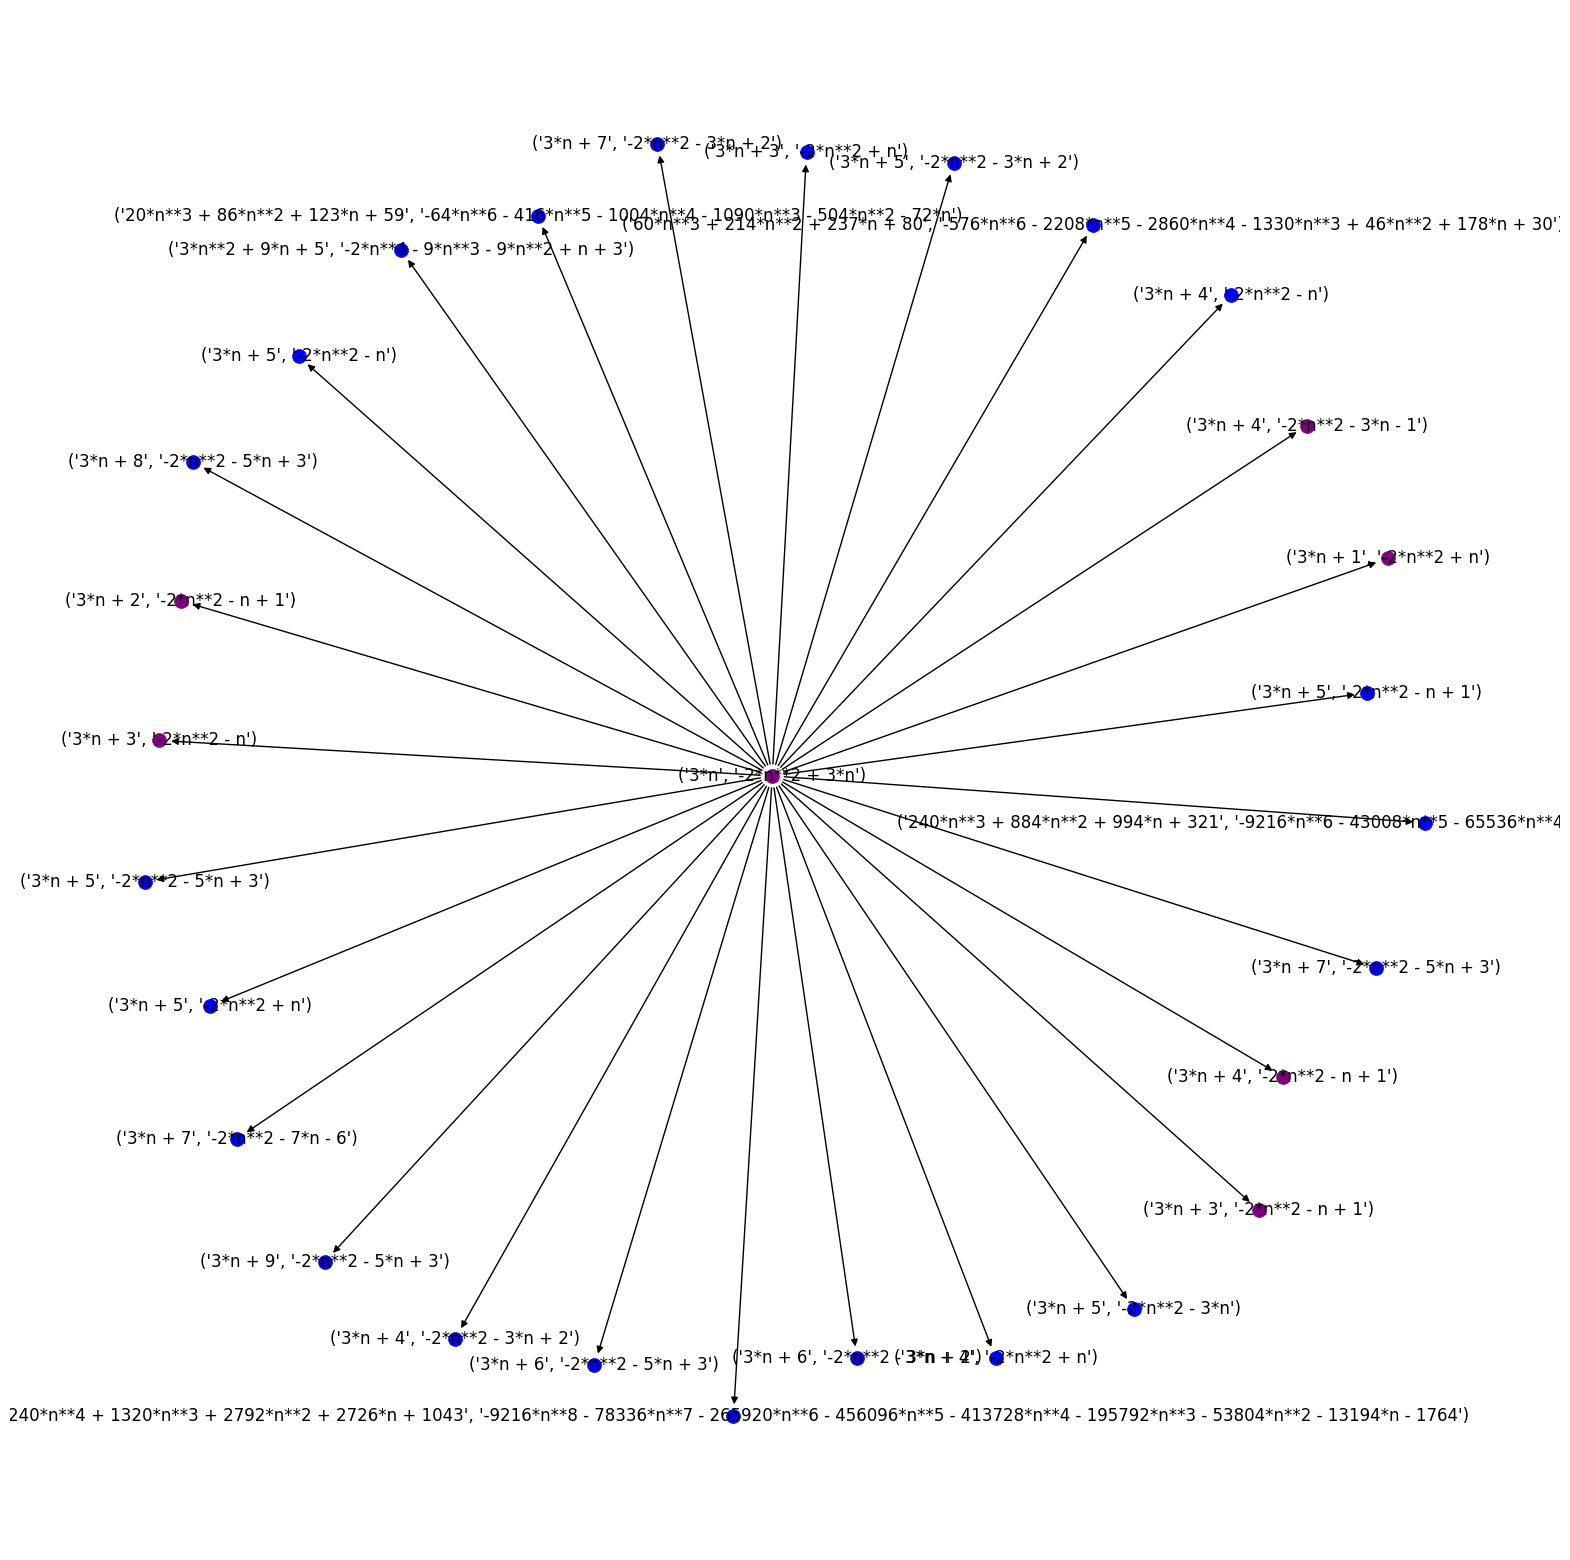

Subgraph with 28 nodes and 27 edges and 1 cc


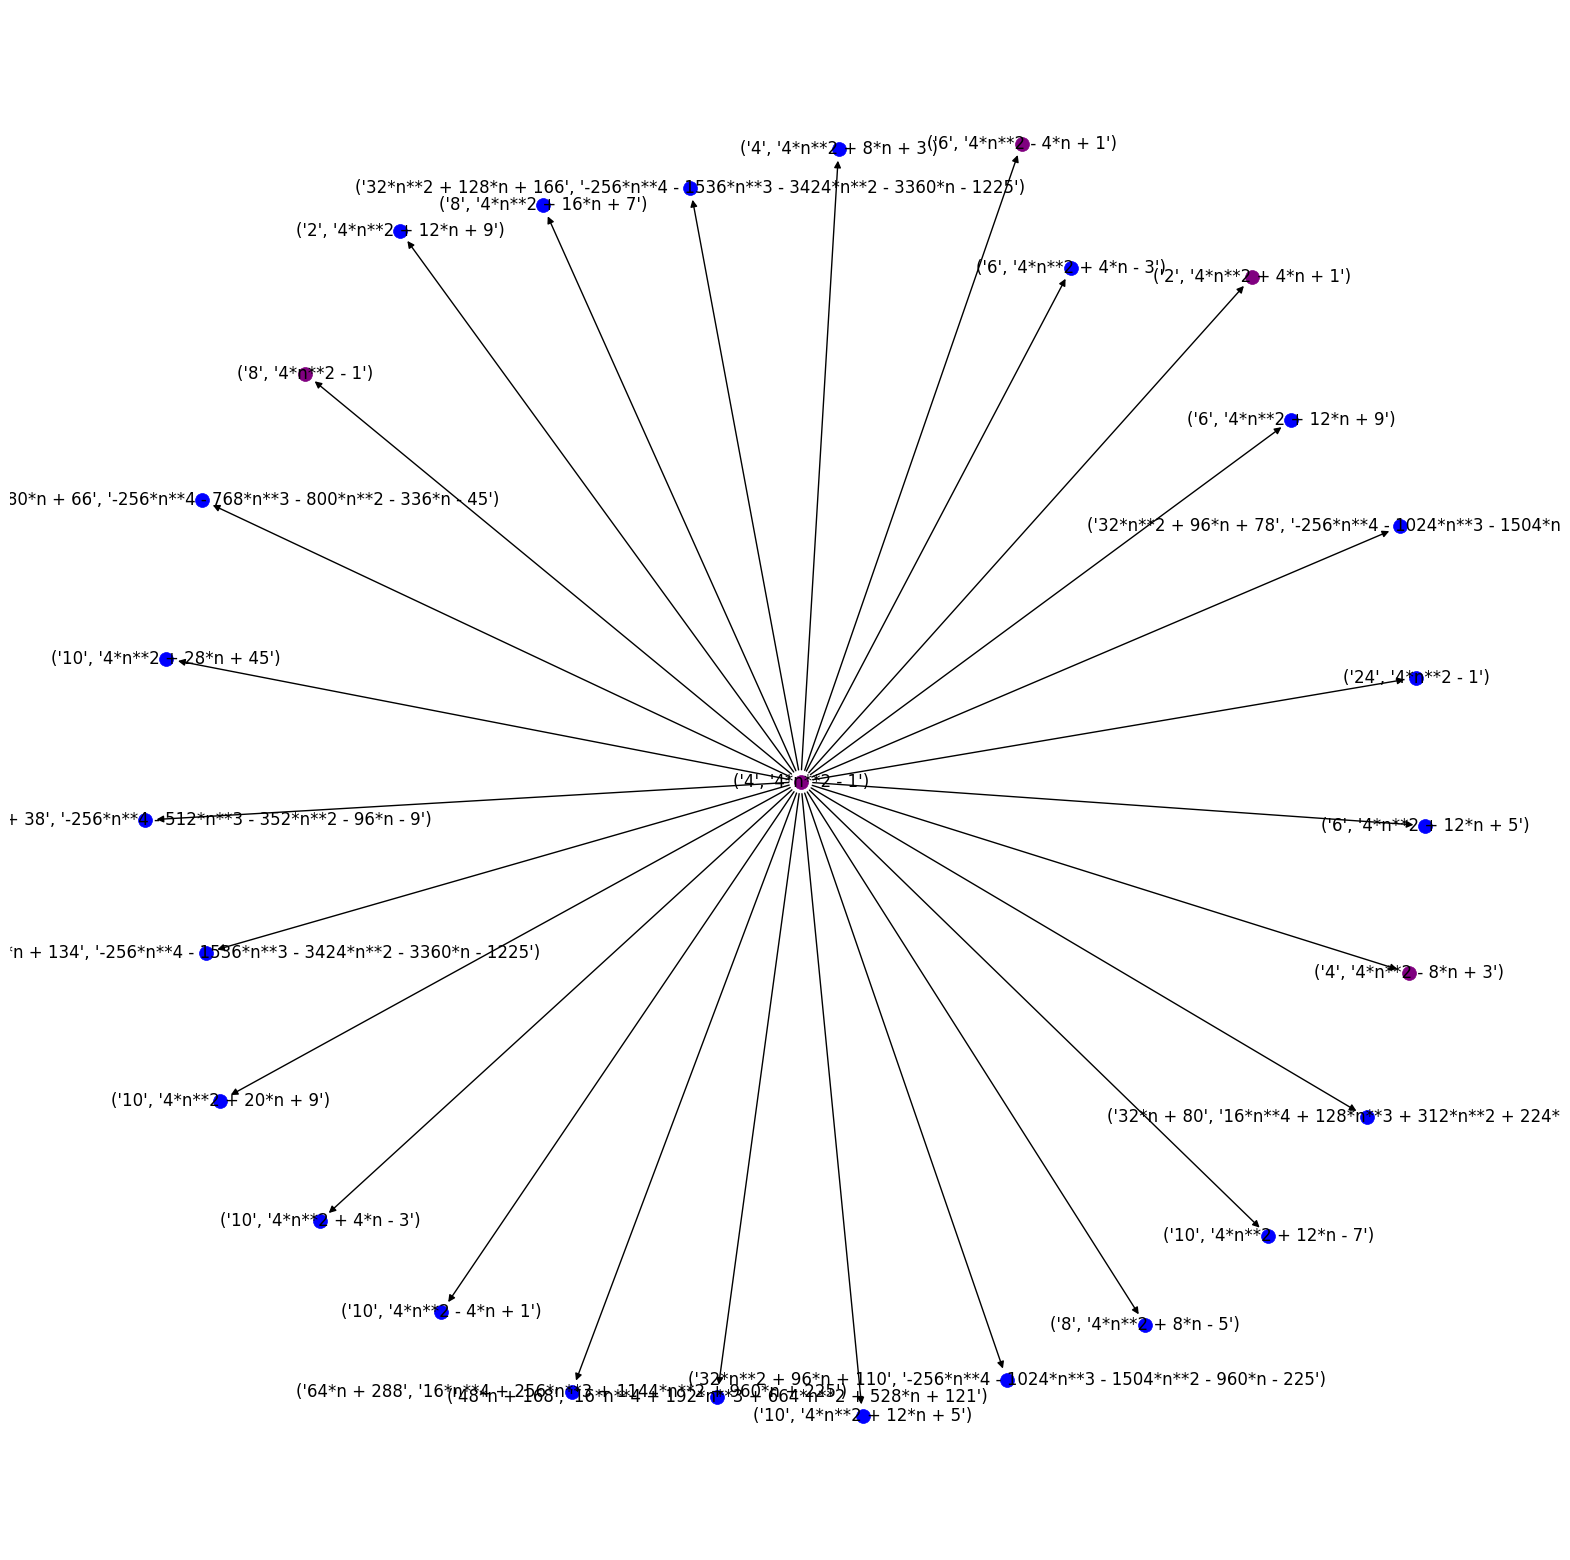

Subgraph with 13 nodes and 12 edges and 1 cc


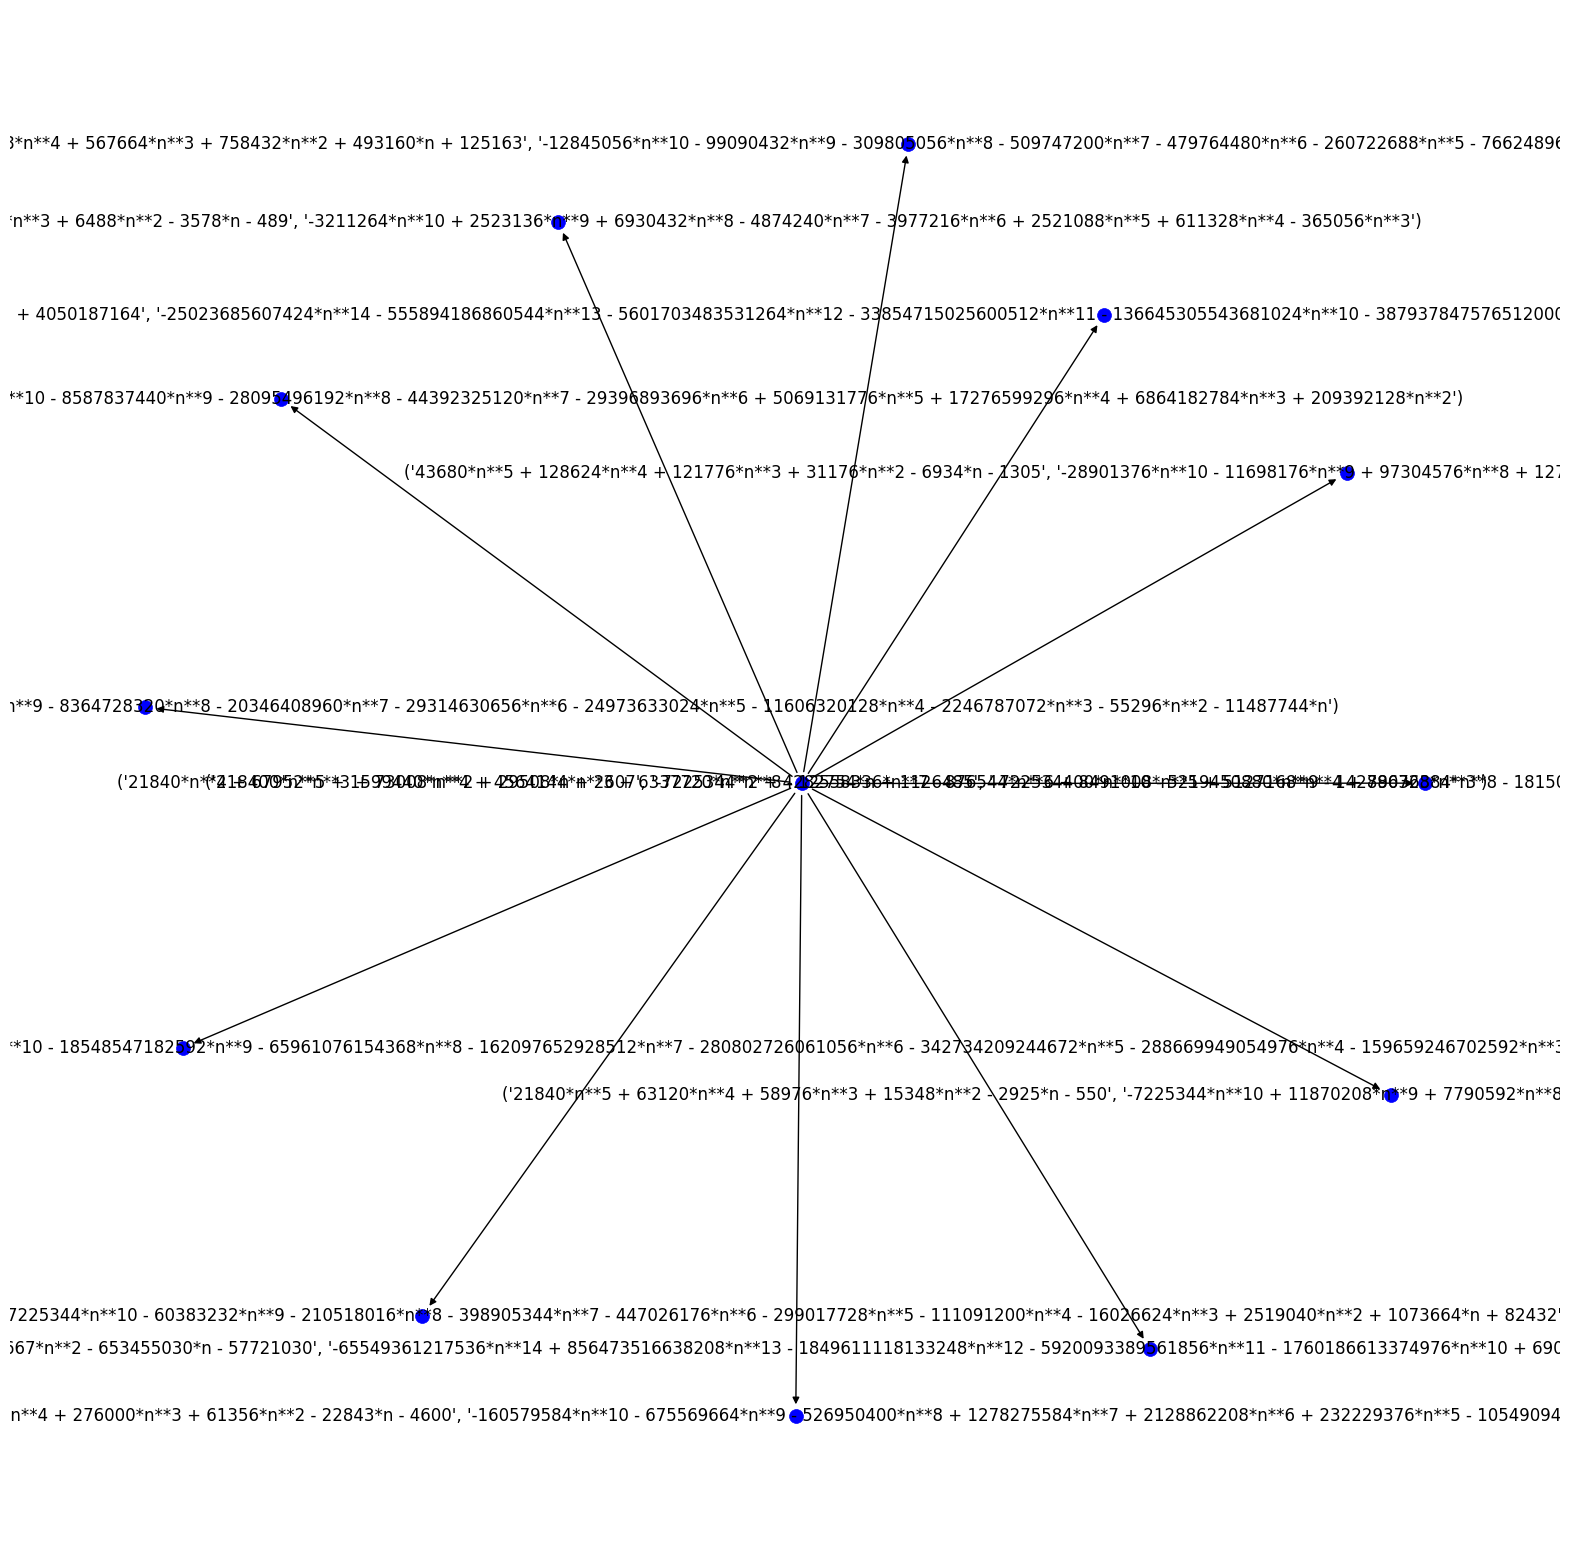

Subgraph with 11 nodes and 10 edges and 1 cc


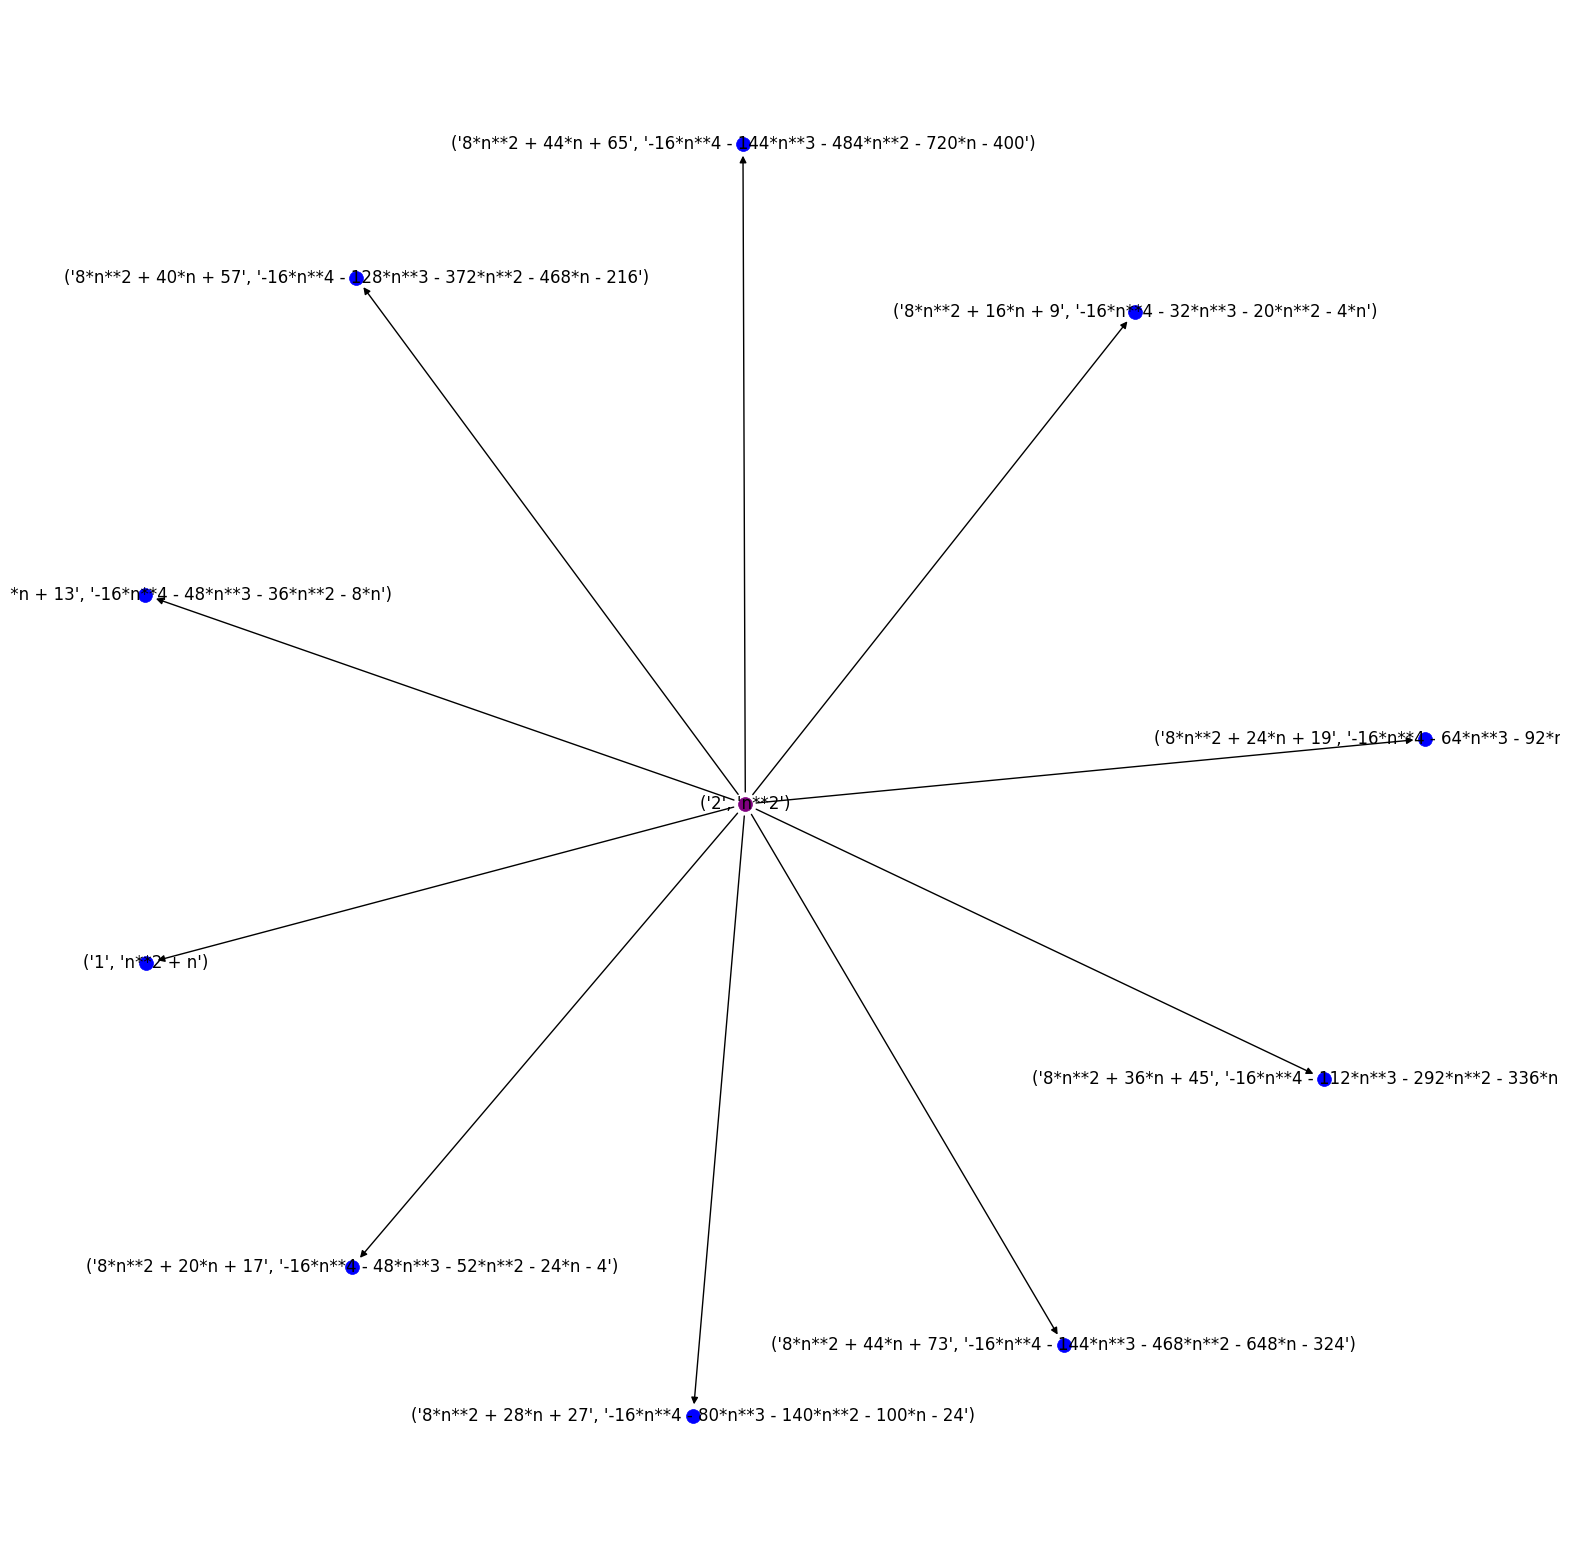

Subgraph with 7 nodes and 6 edges and 1 cc


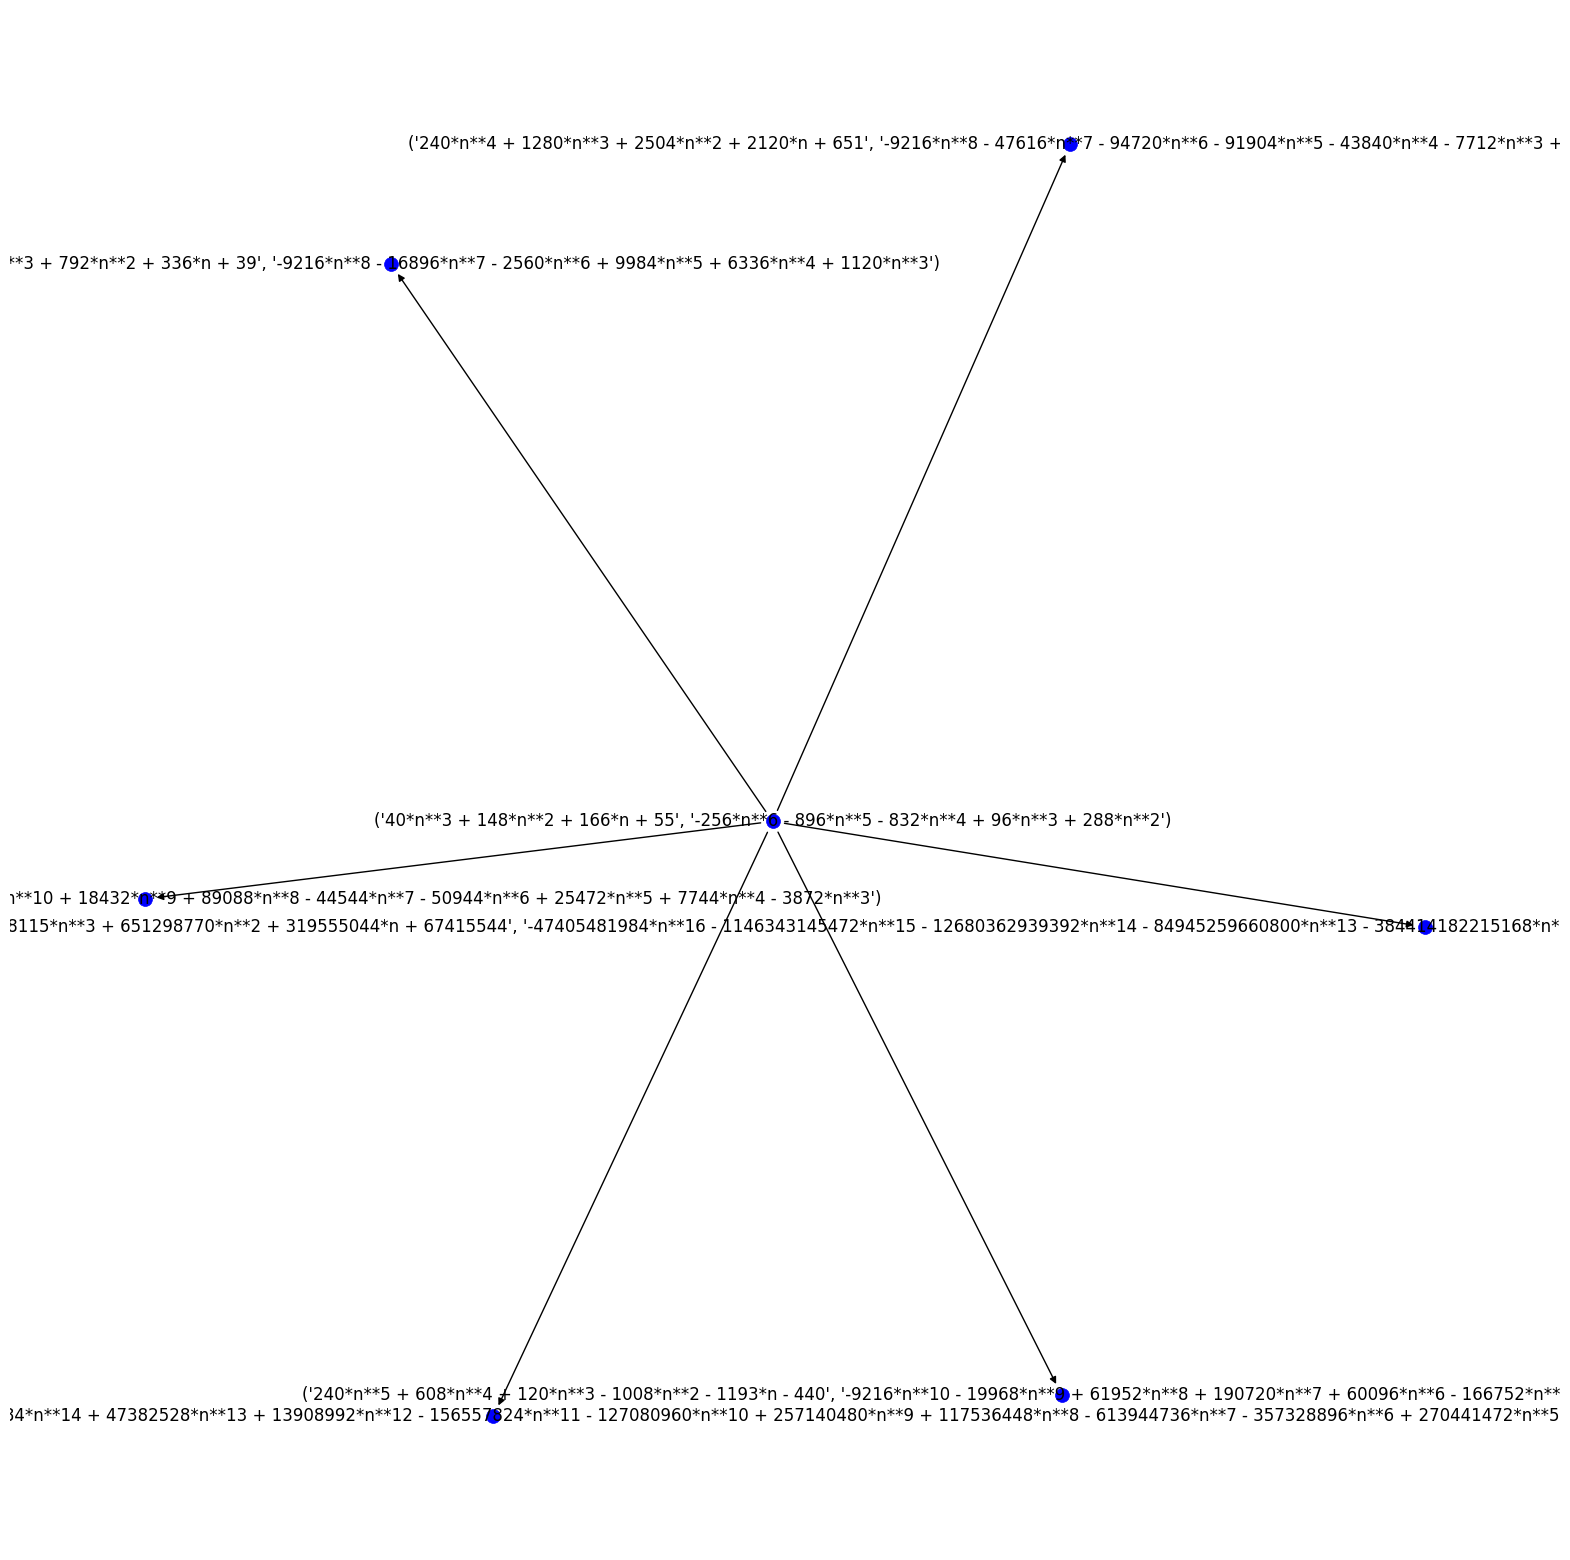

Subgraph with 6 nodes and 5 edges and 1 cc


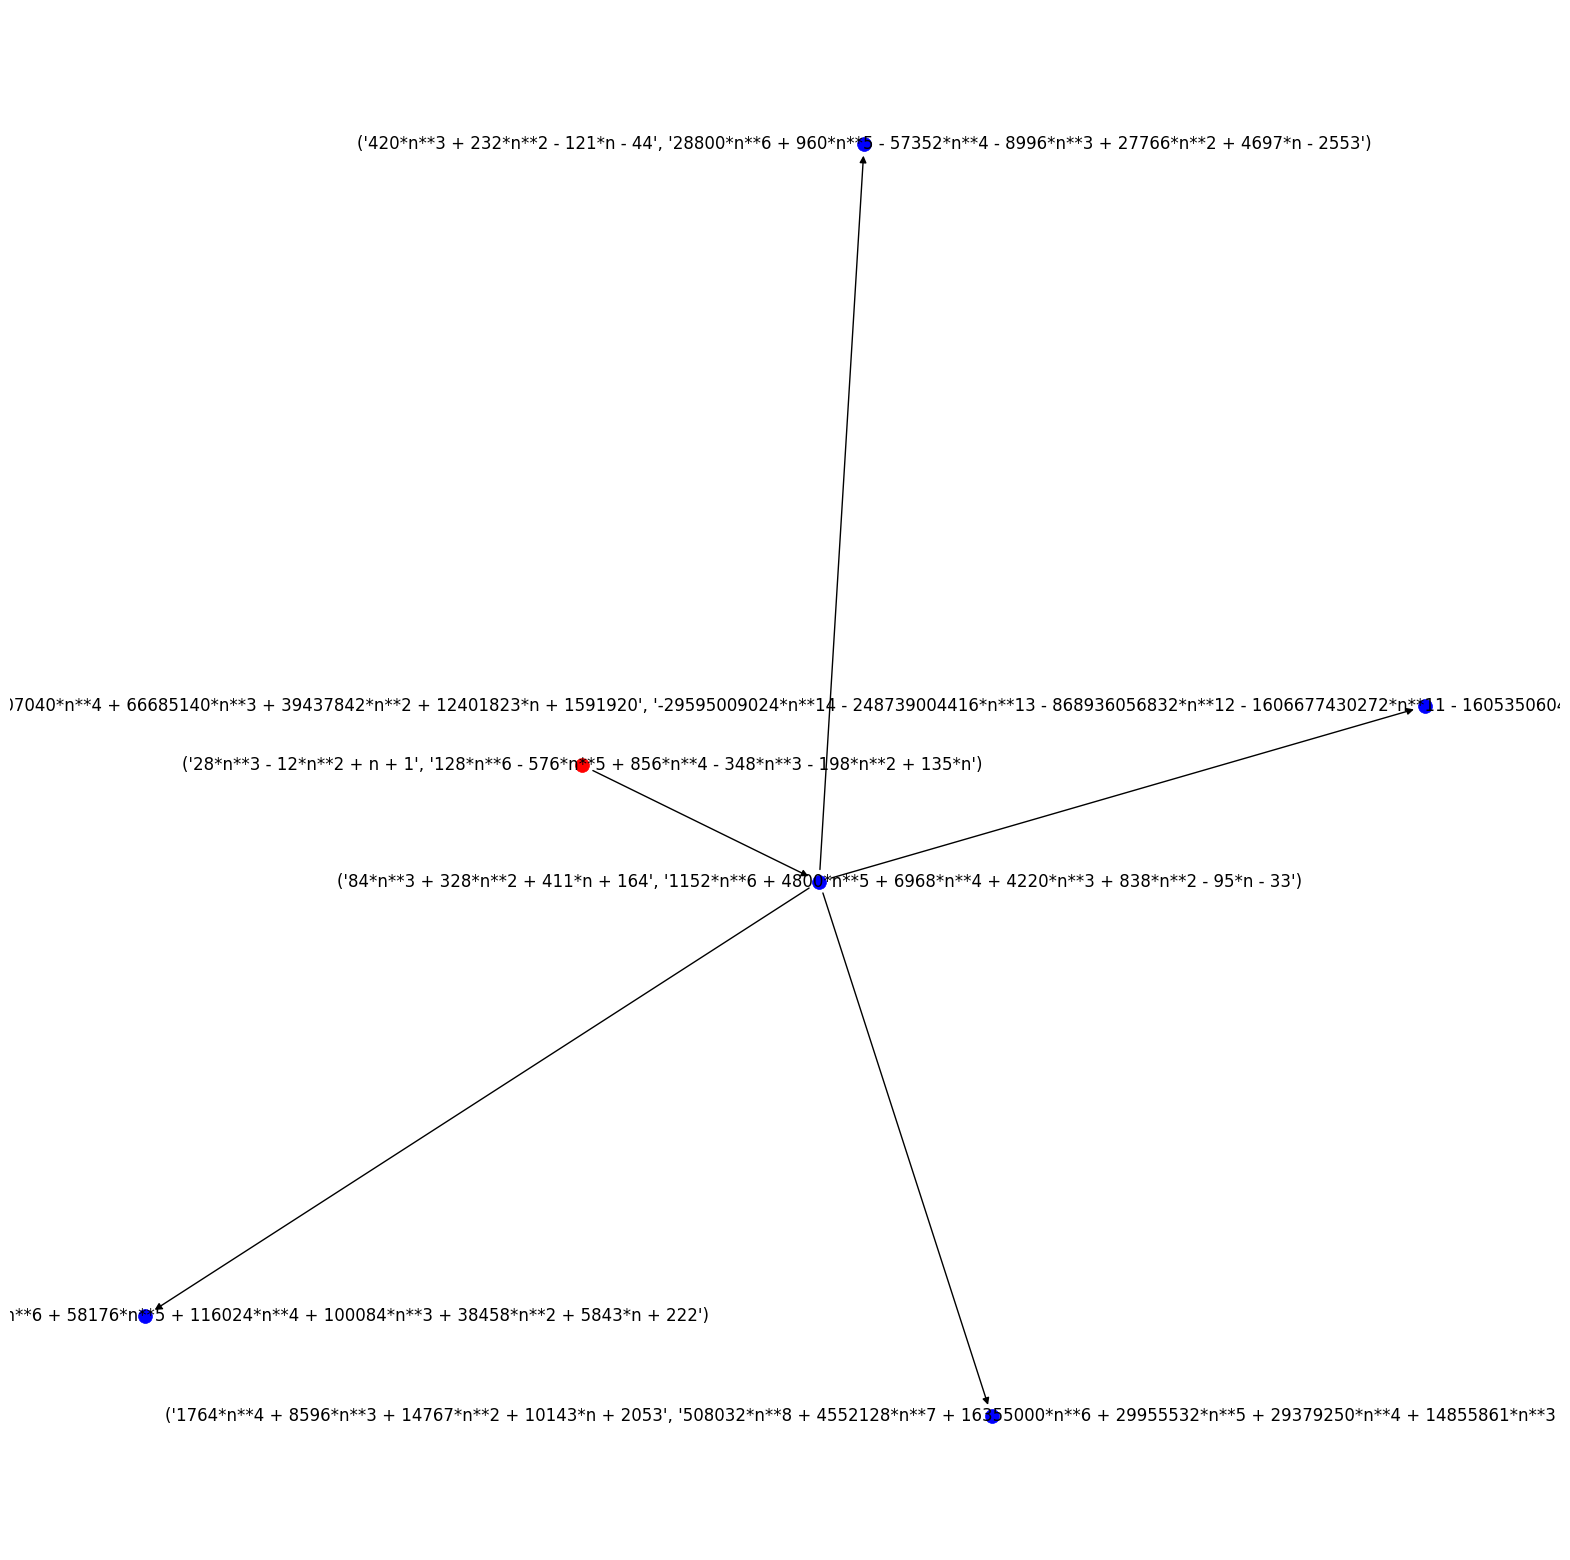

Subgraph with 5 nodes and 4 edges and 1 cc


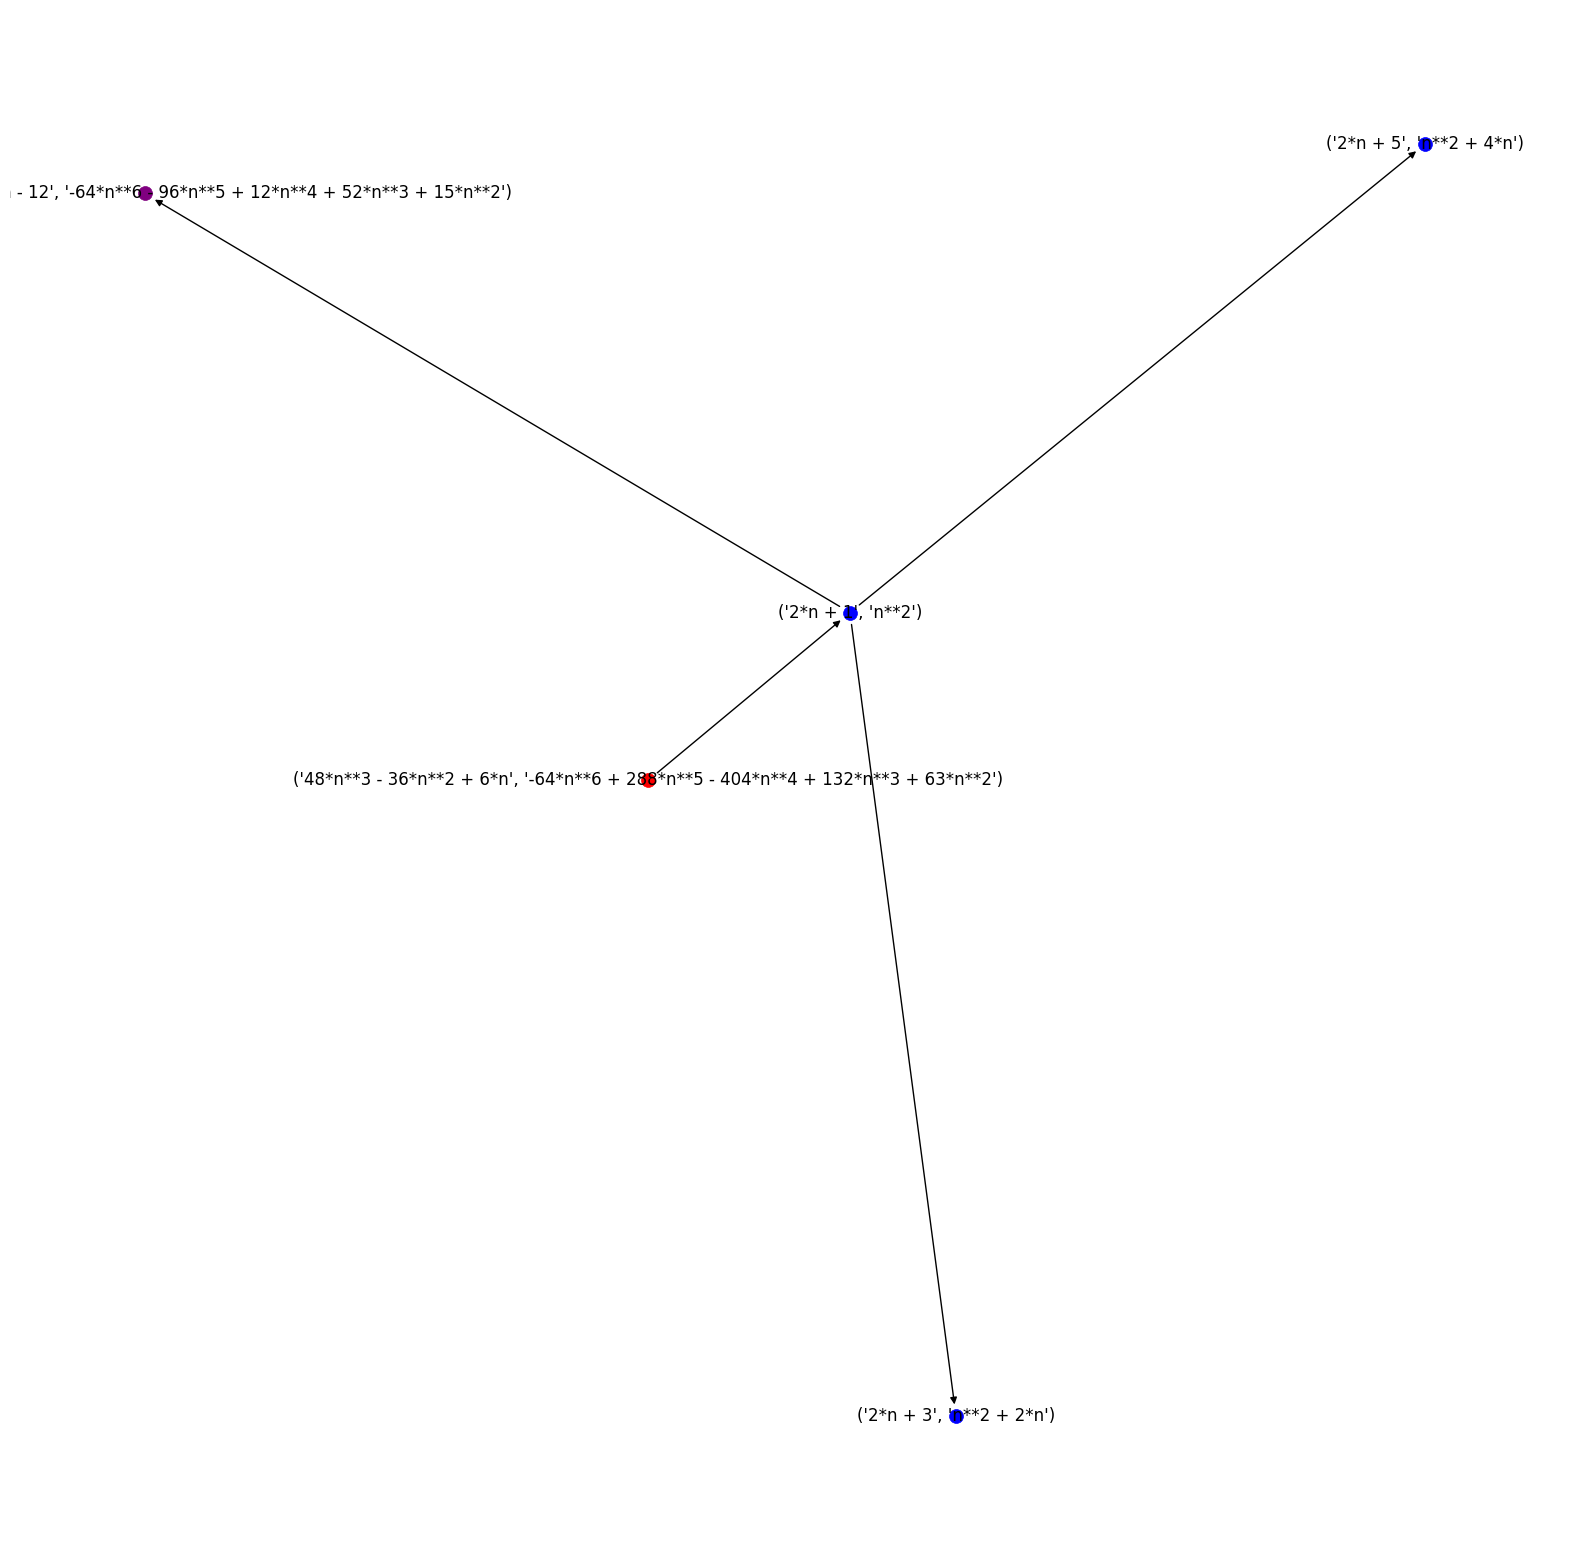

Subgraph with 5 nodes and 4 edges and 1 cc


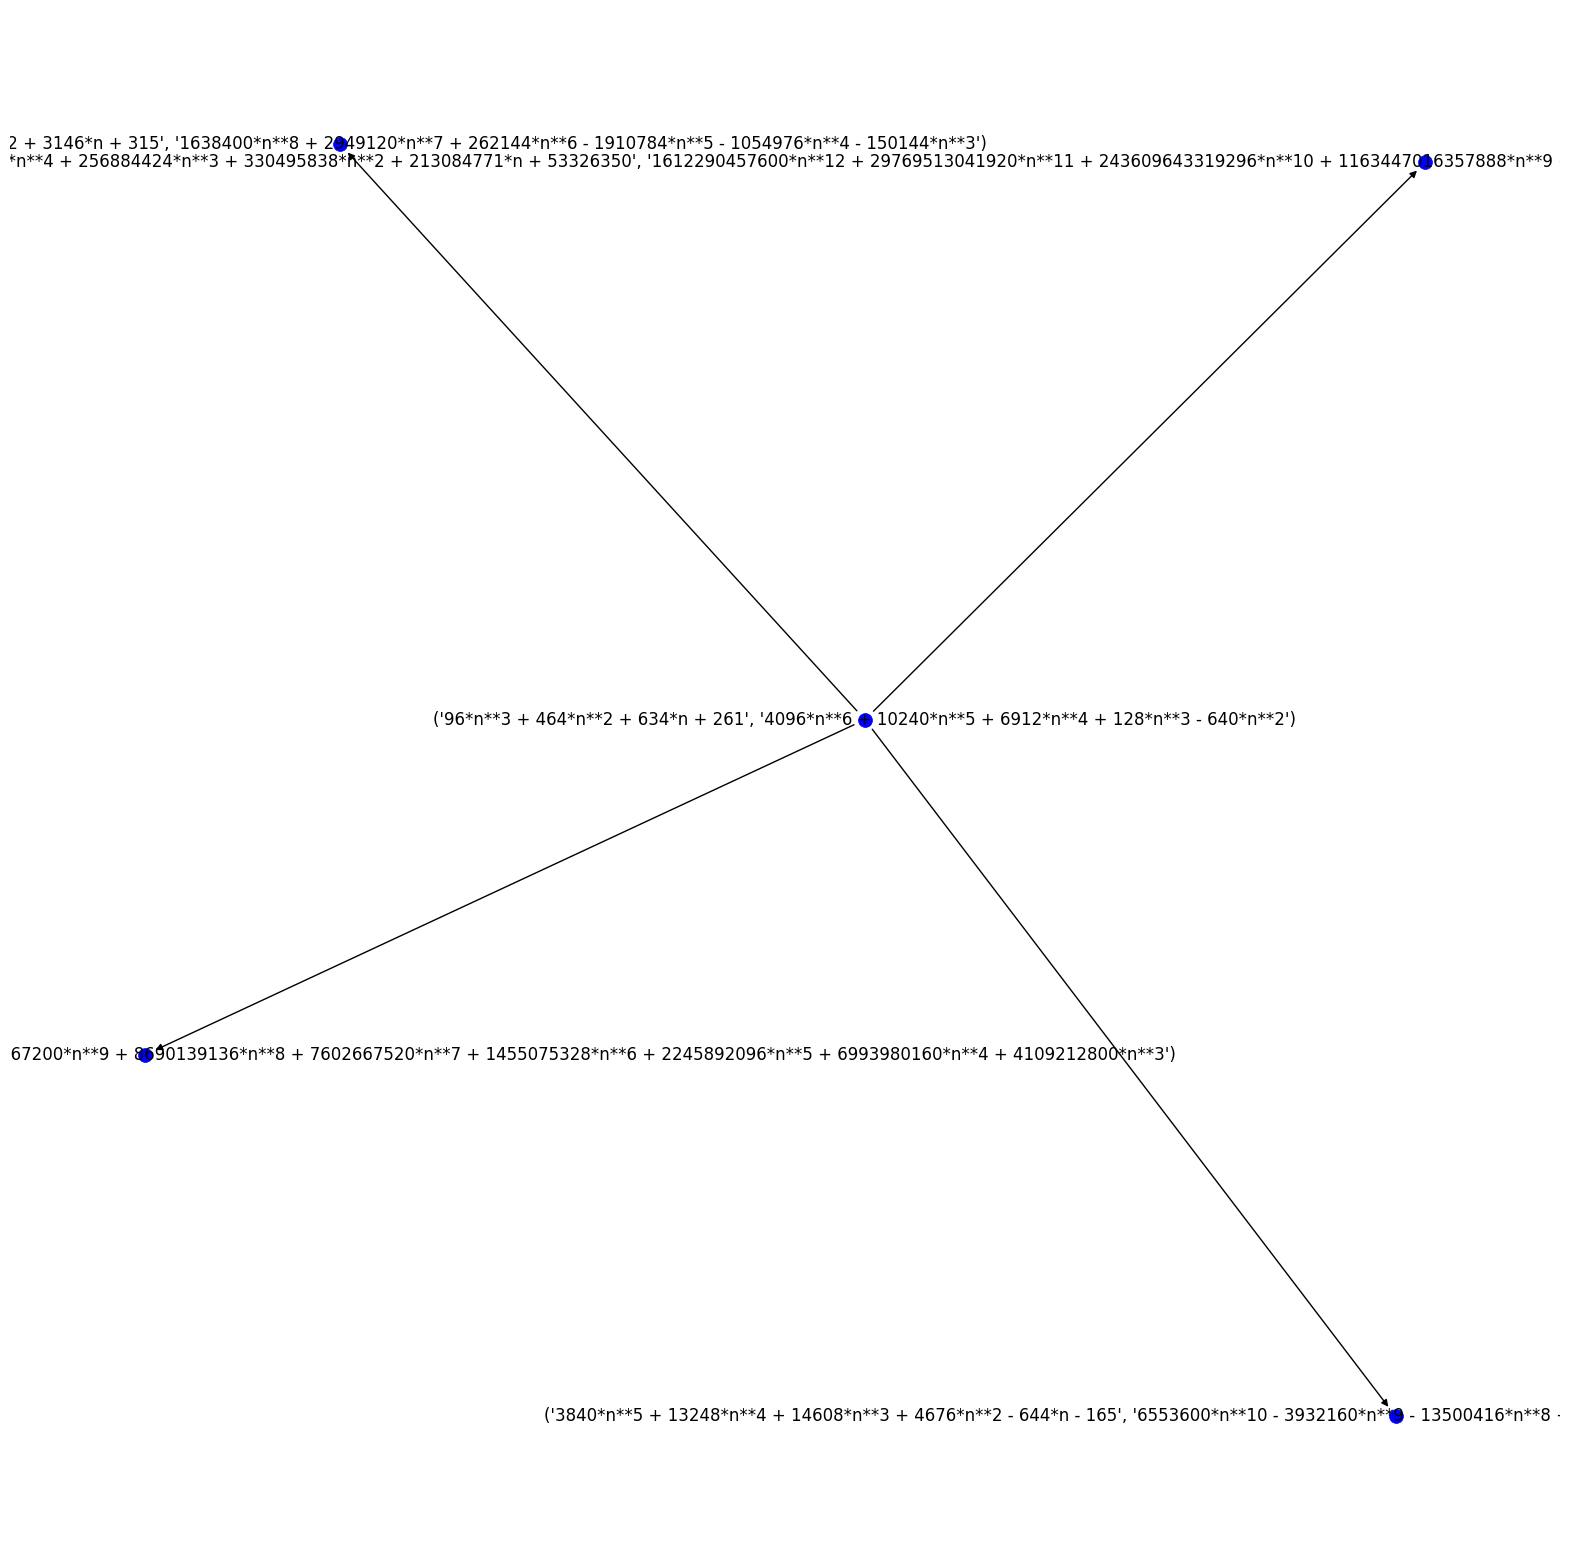

Subgraph with 5 nodes and 4 edges and 1 cc


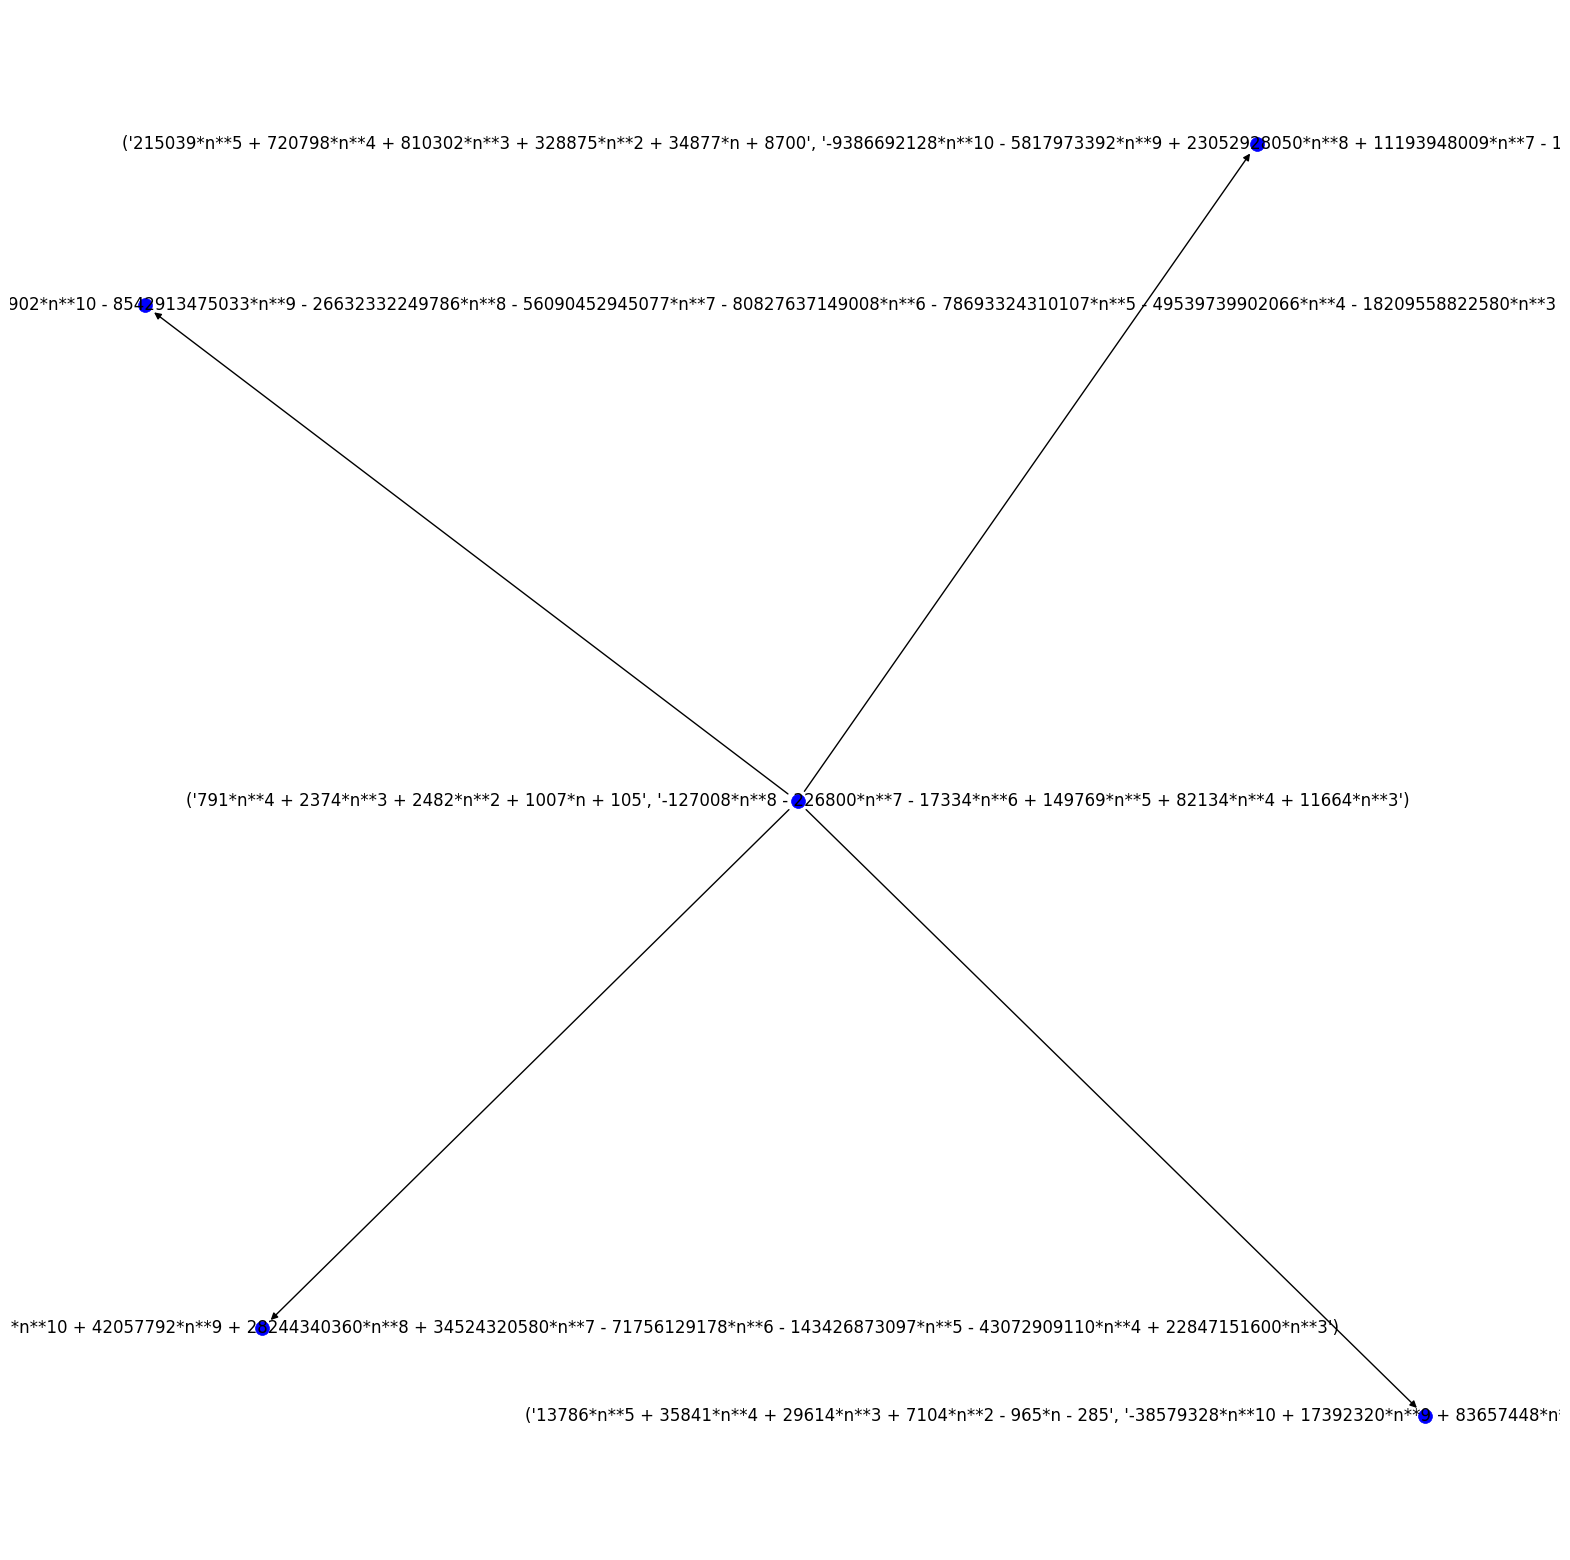

Subgraph with 5 nodes and 4 edges and 1 cc


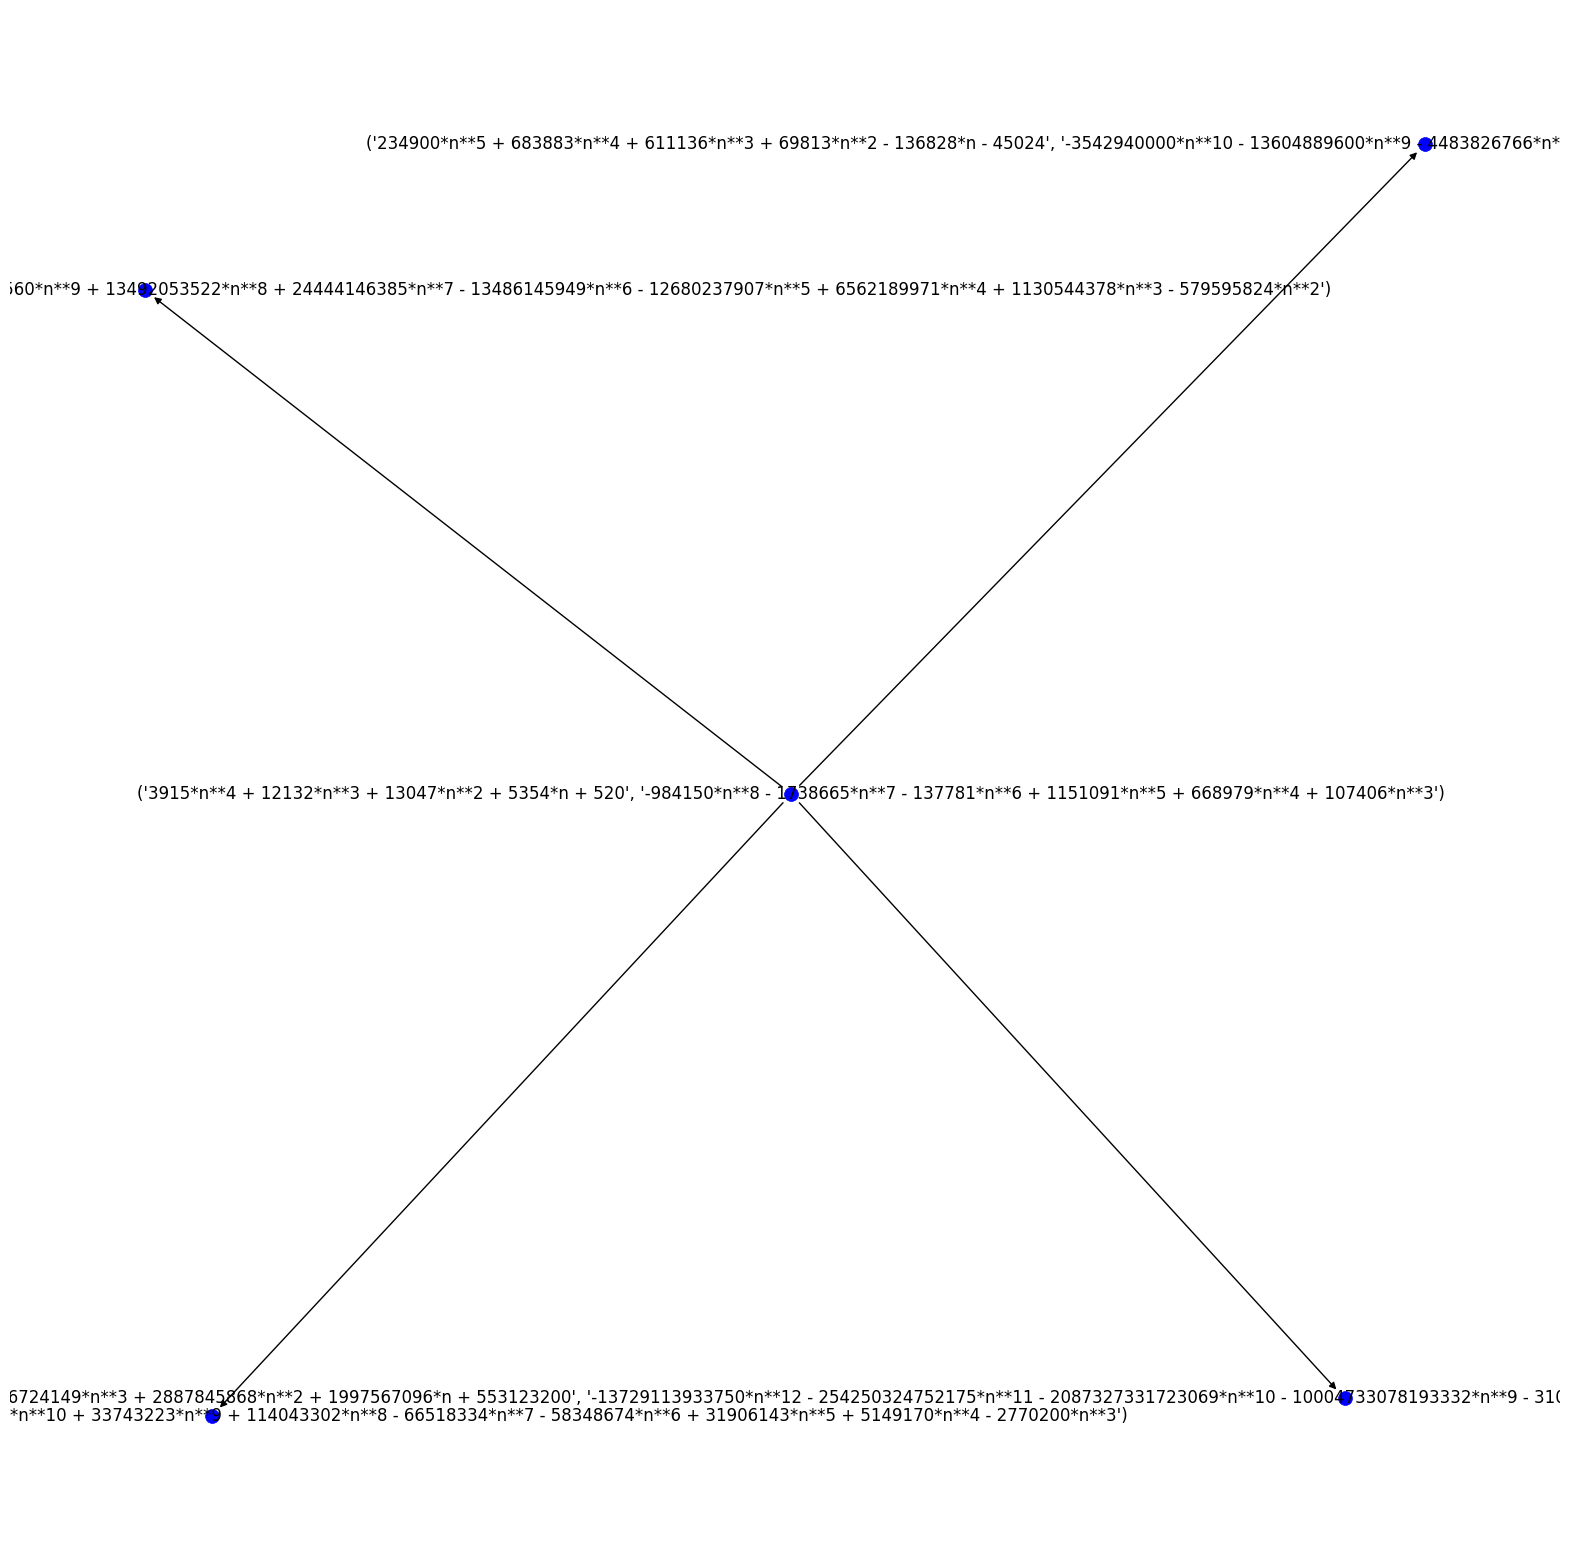

Subgraph with 4 nodes and 3 edges and 1 cc


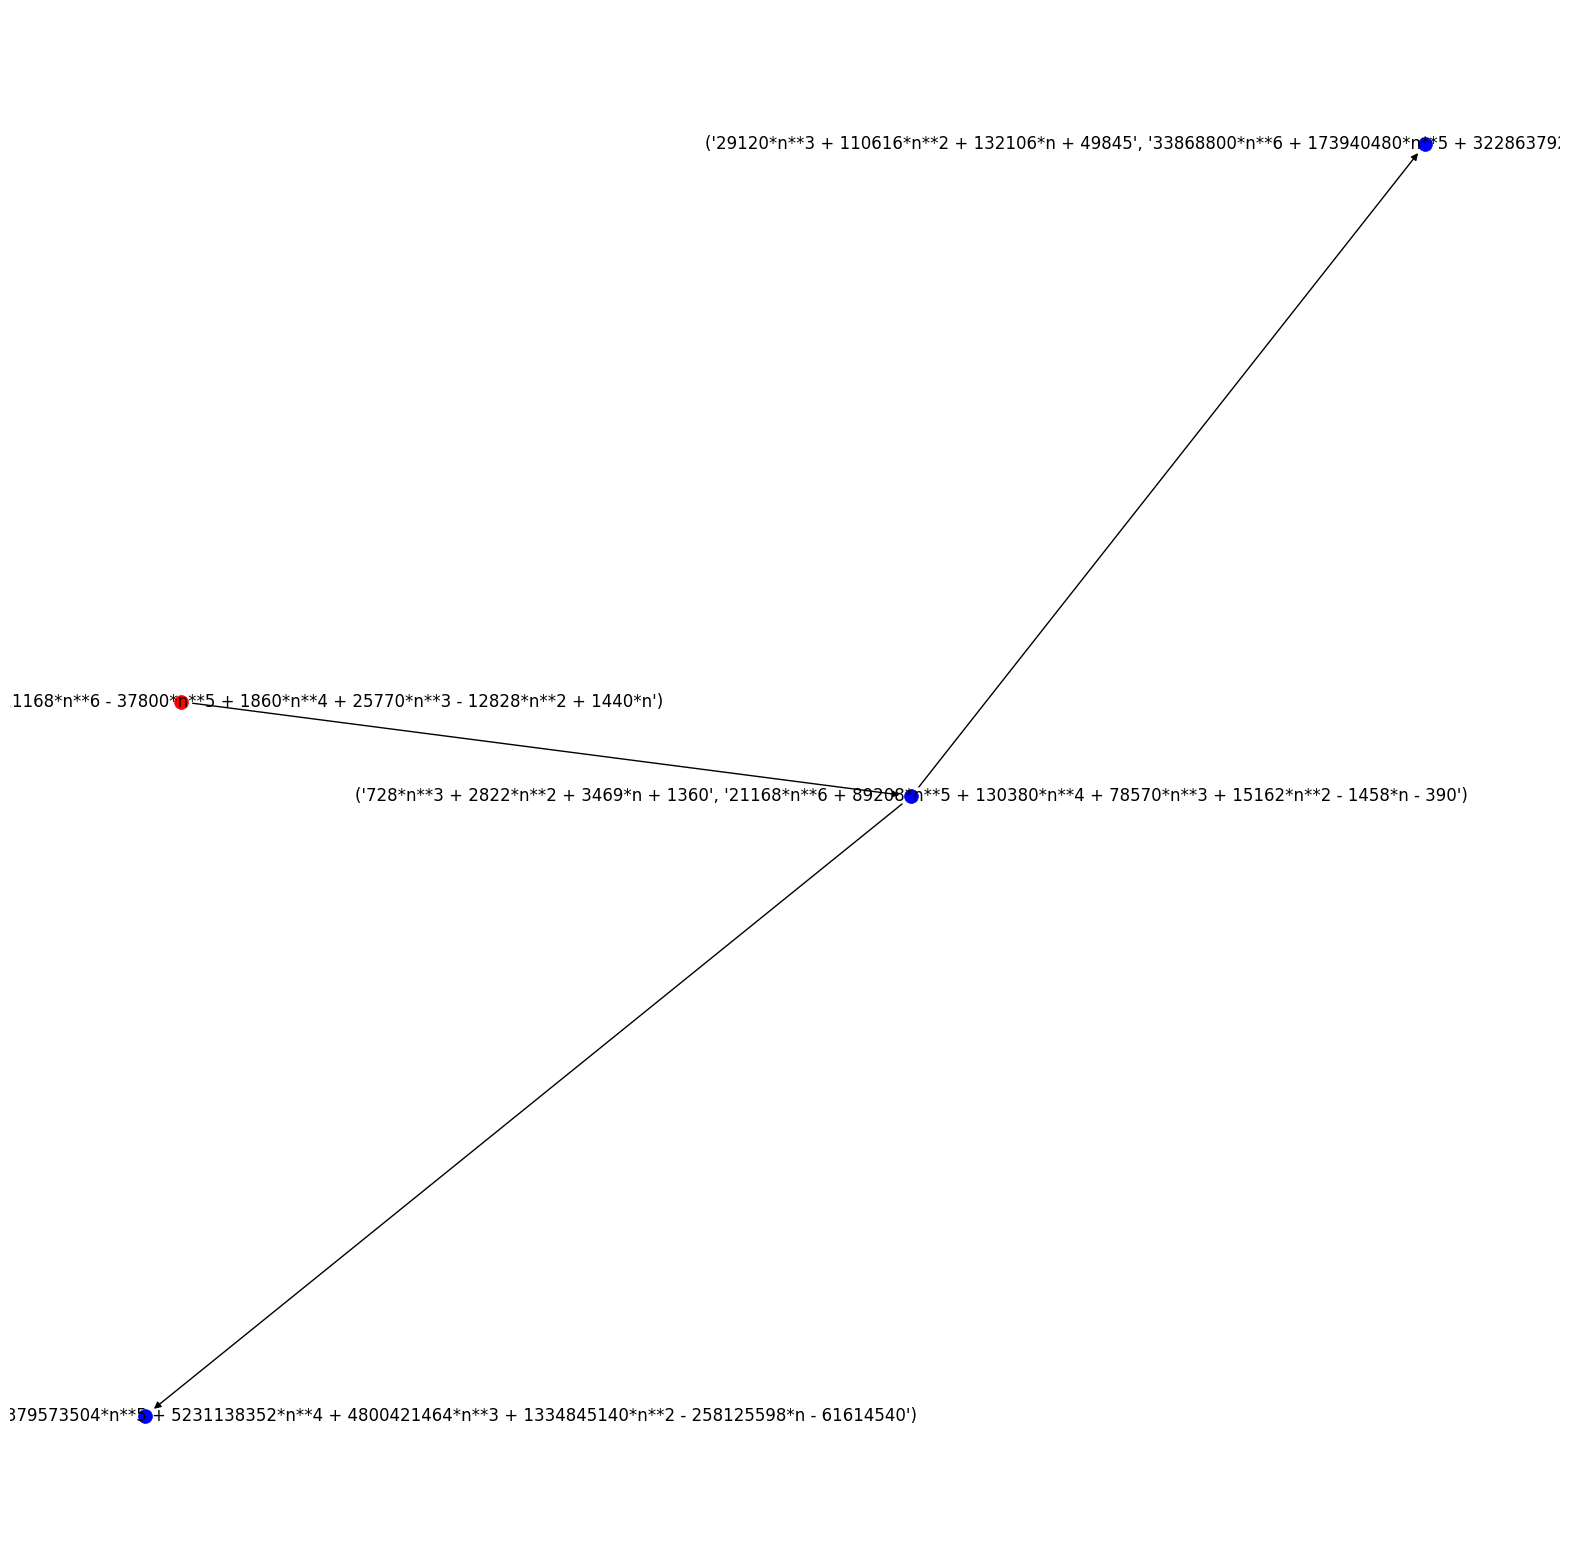

Subgraph with 4 nodes and 3 edges and 1 cc


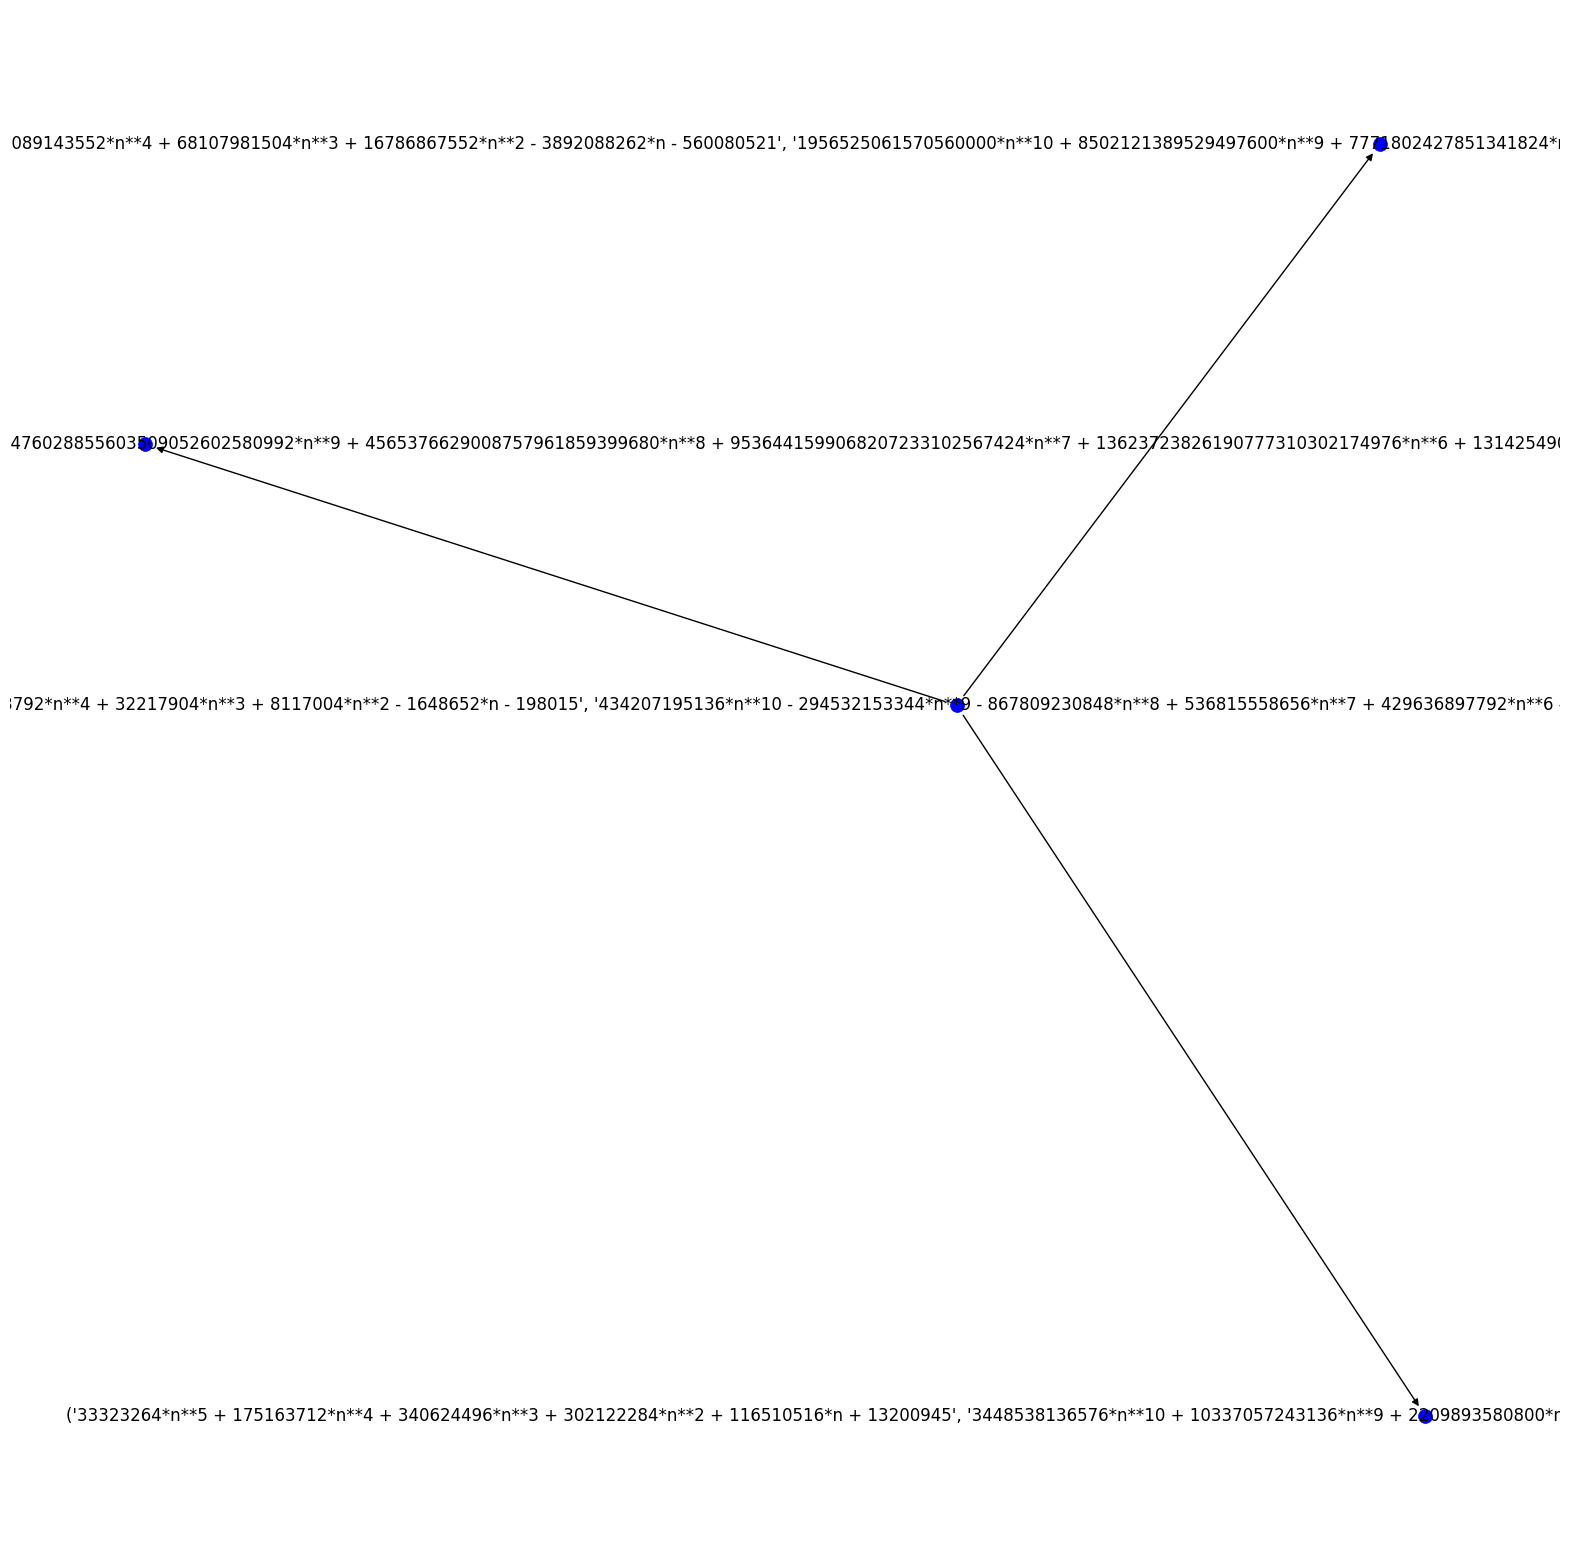

Subgraph with 4 nodes and 3 edges and 1 cc


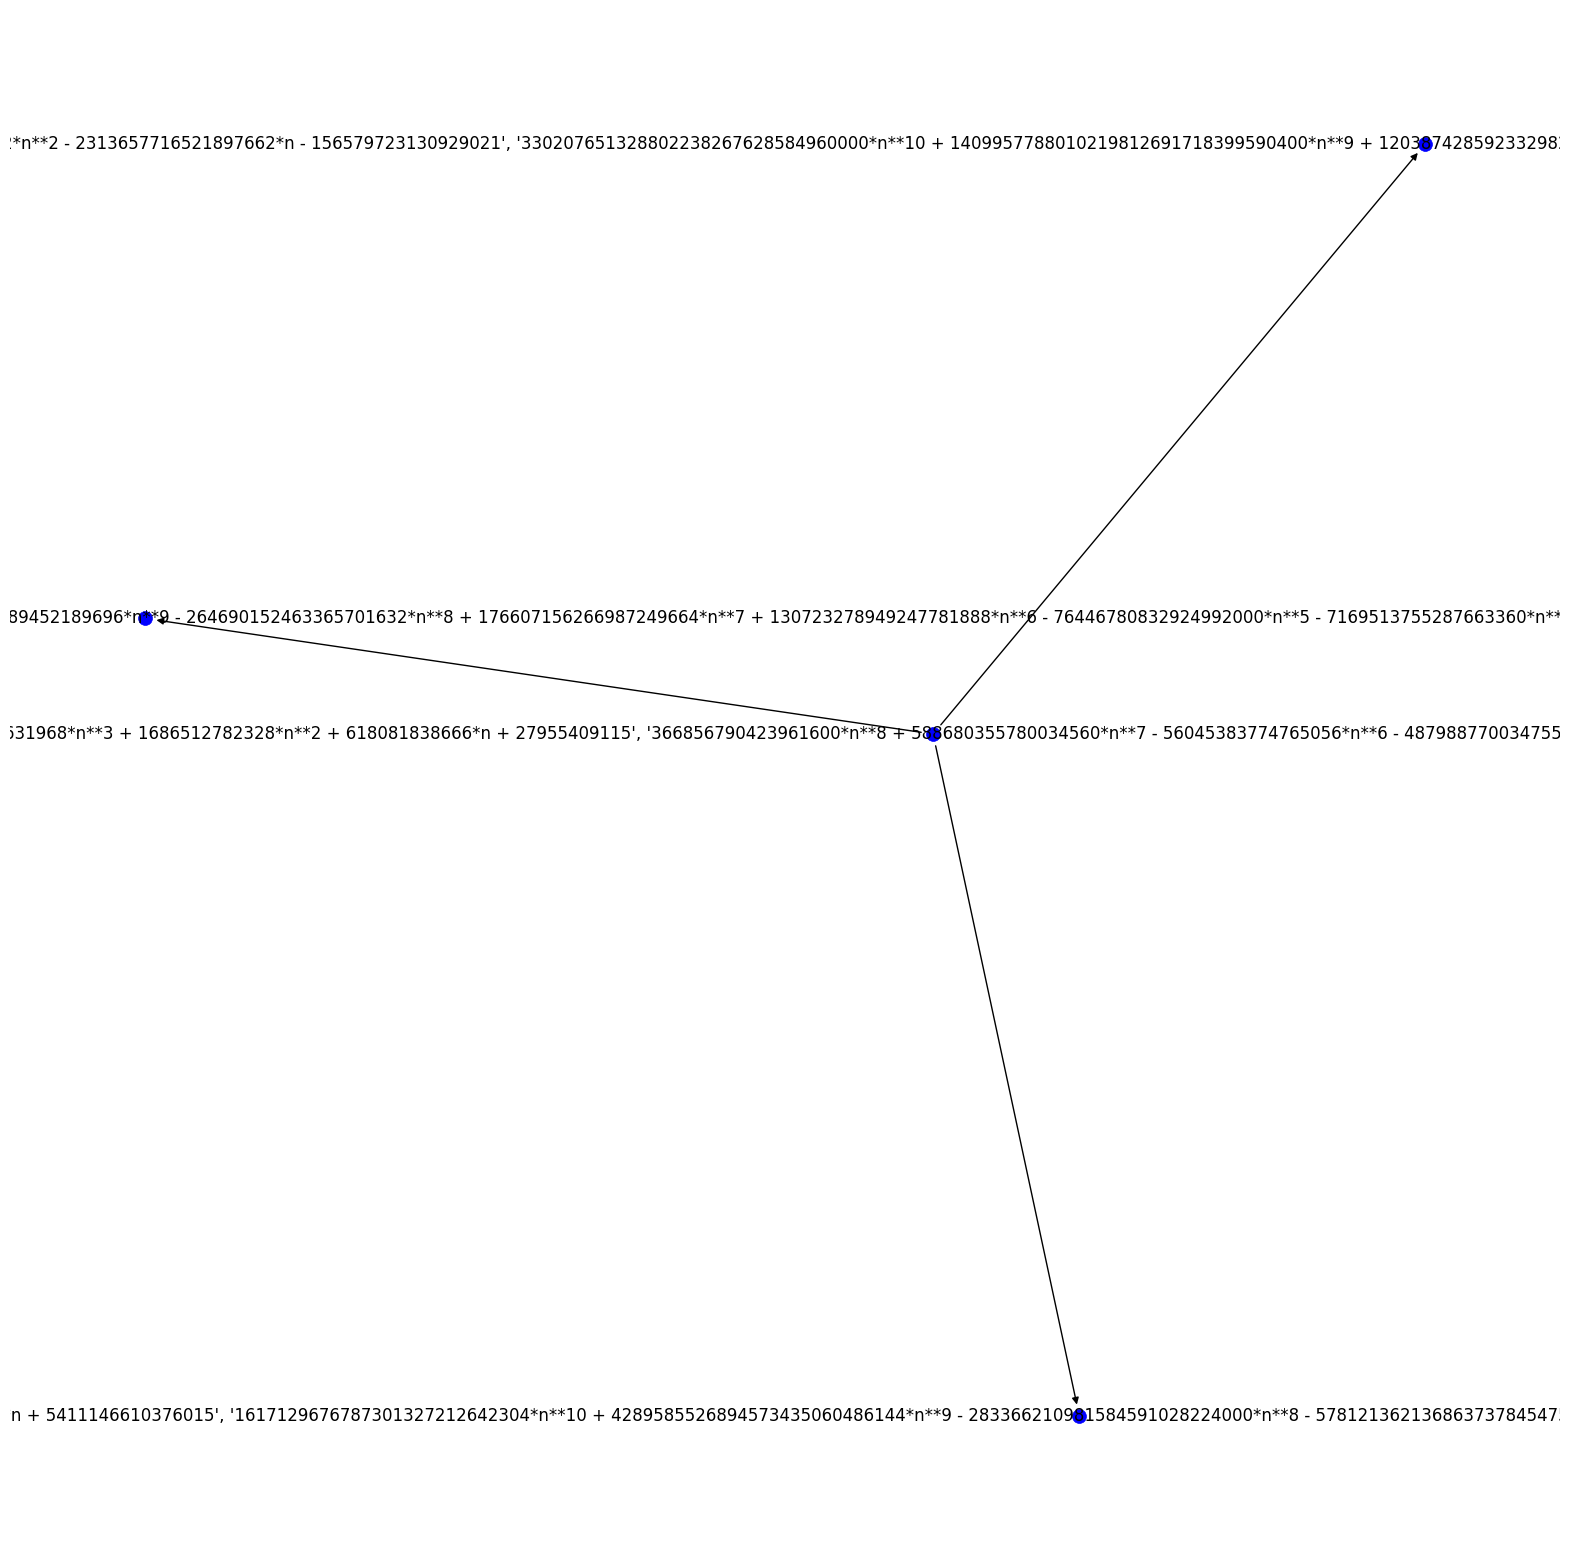

Subgraph with 3 nodes and 2 edges and 1 cc


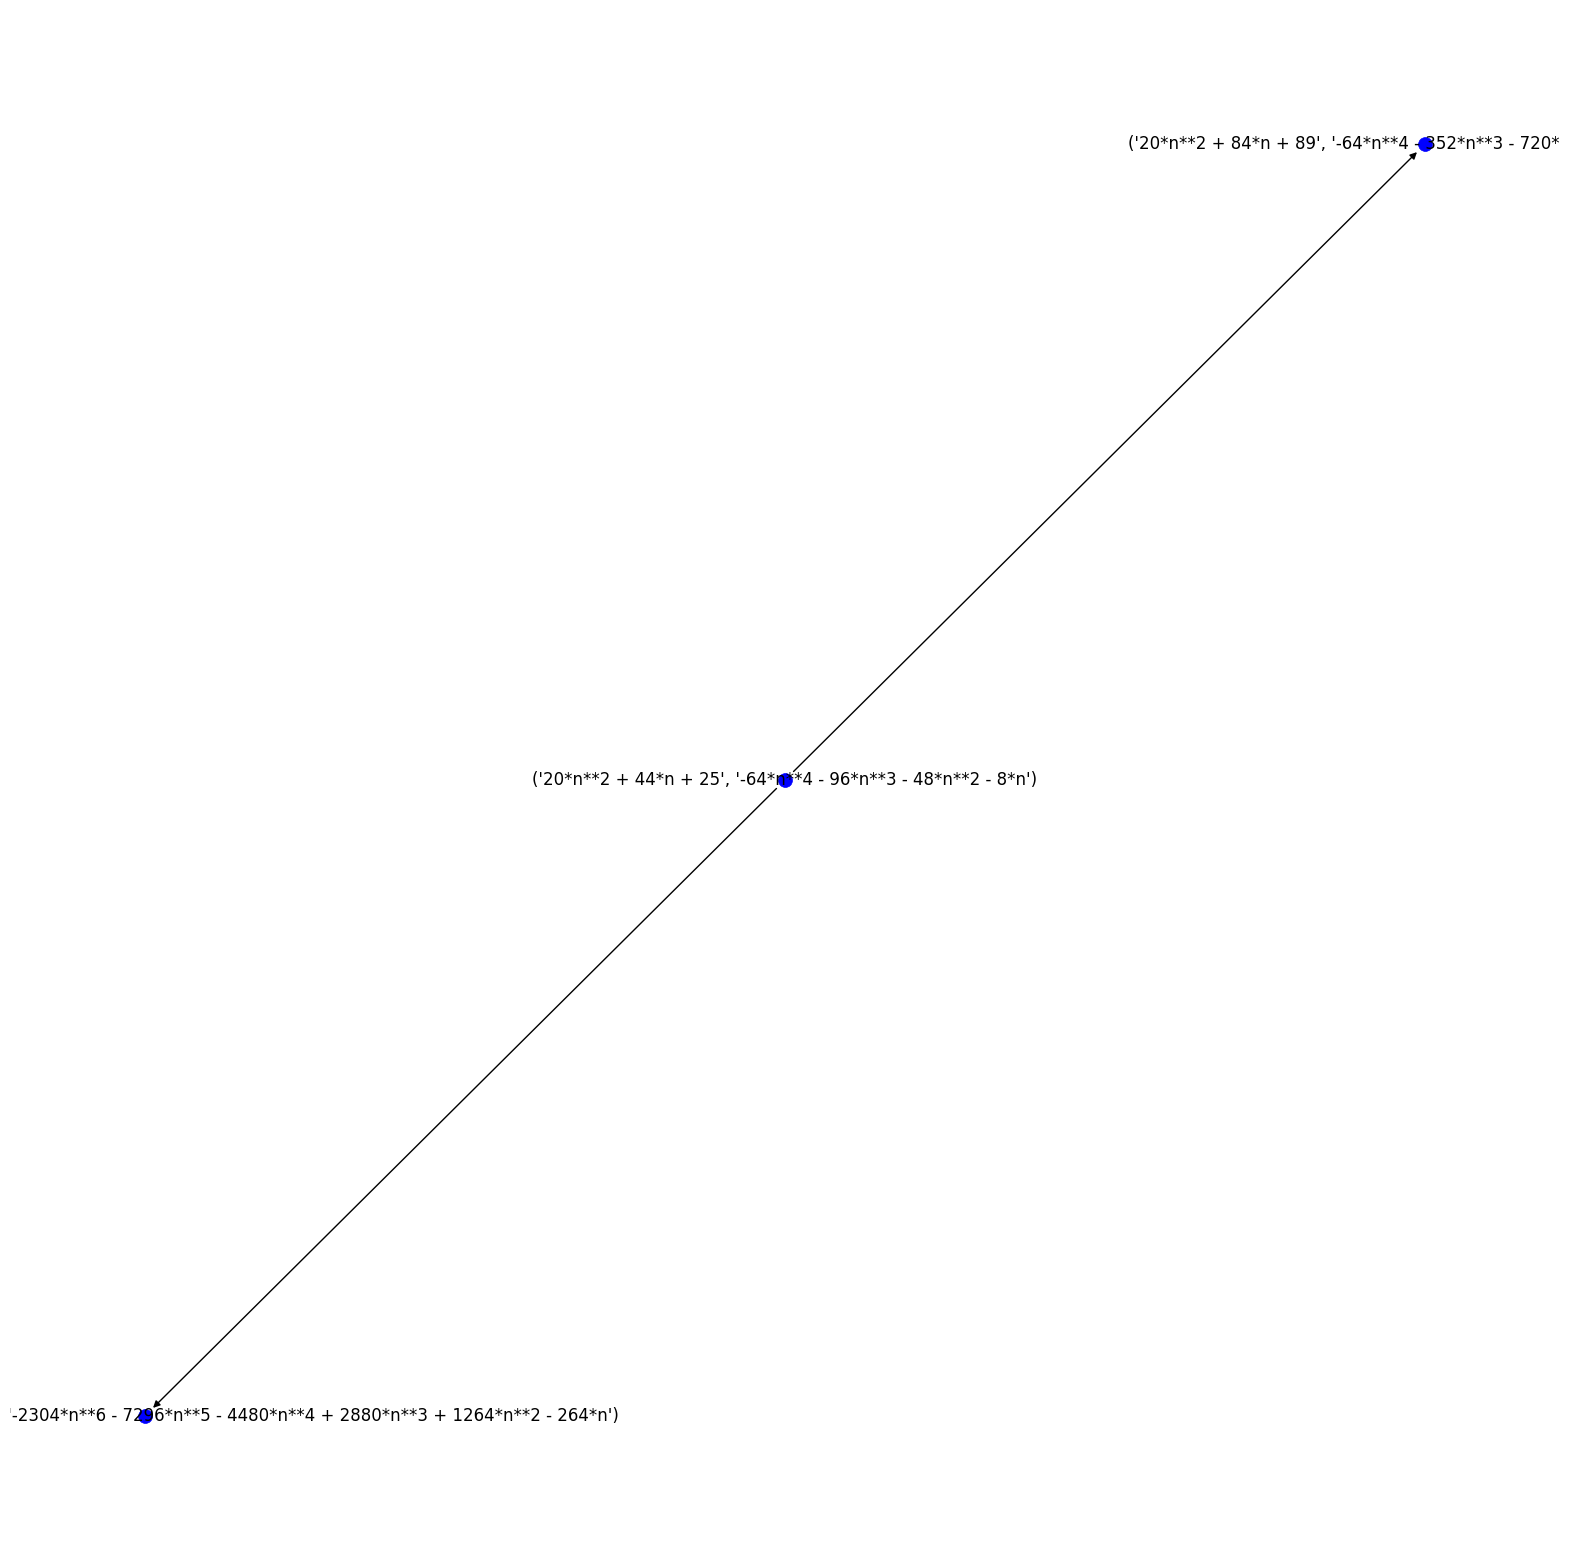

Subgraph with 3 nodes and 2 edges and 1 cc


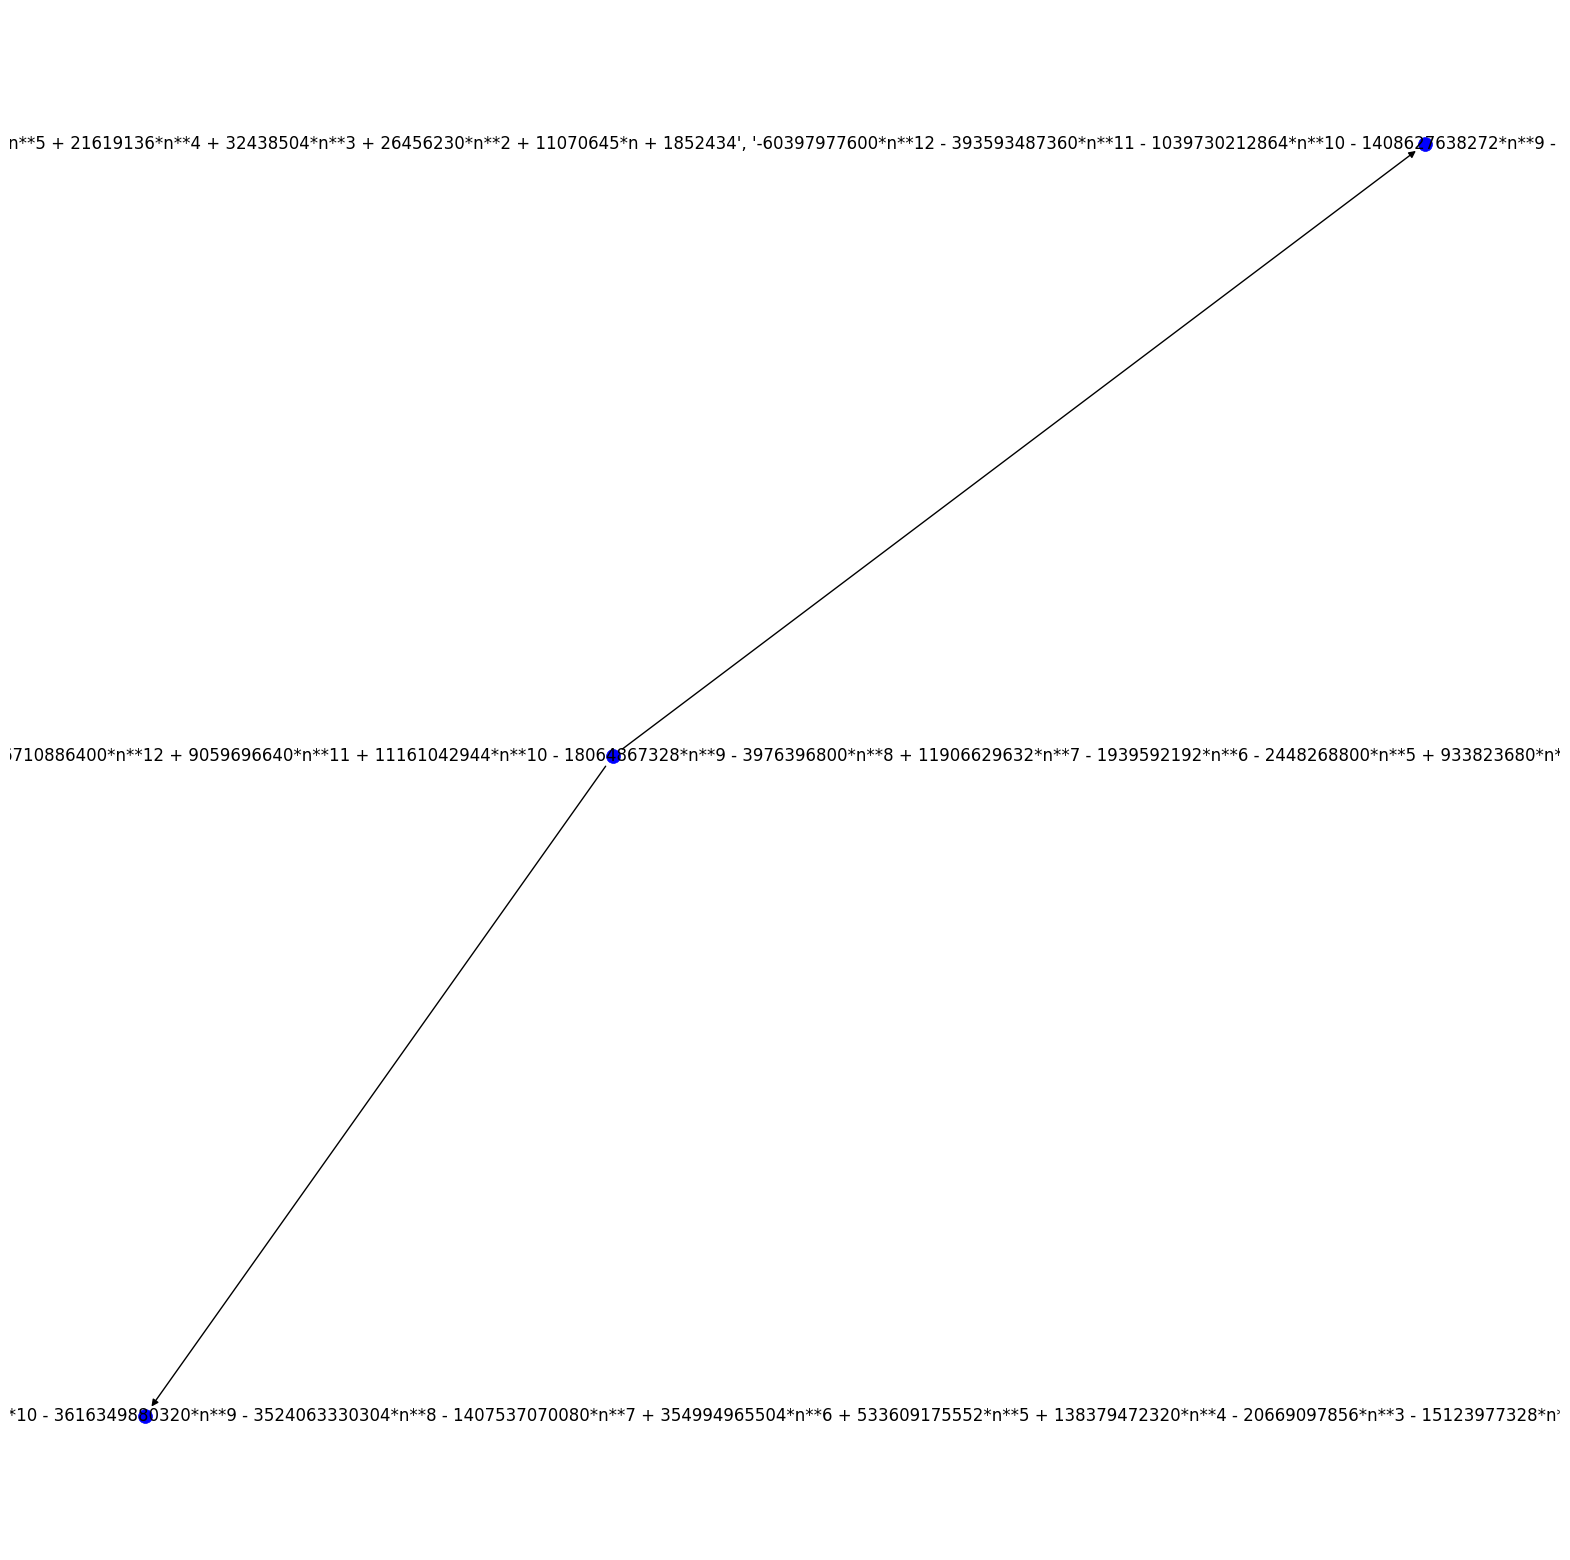

Subgraph with 2 nodes and 1 edges and 1 cc


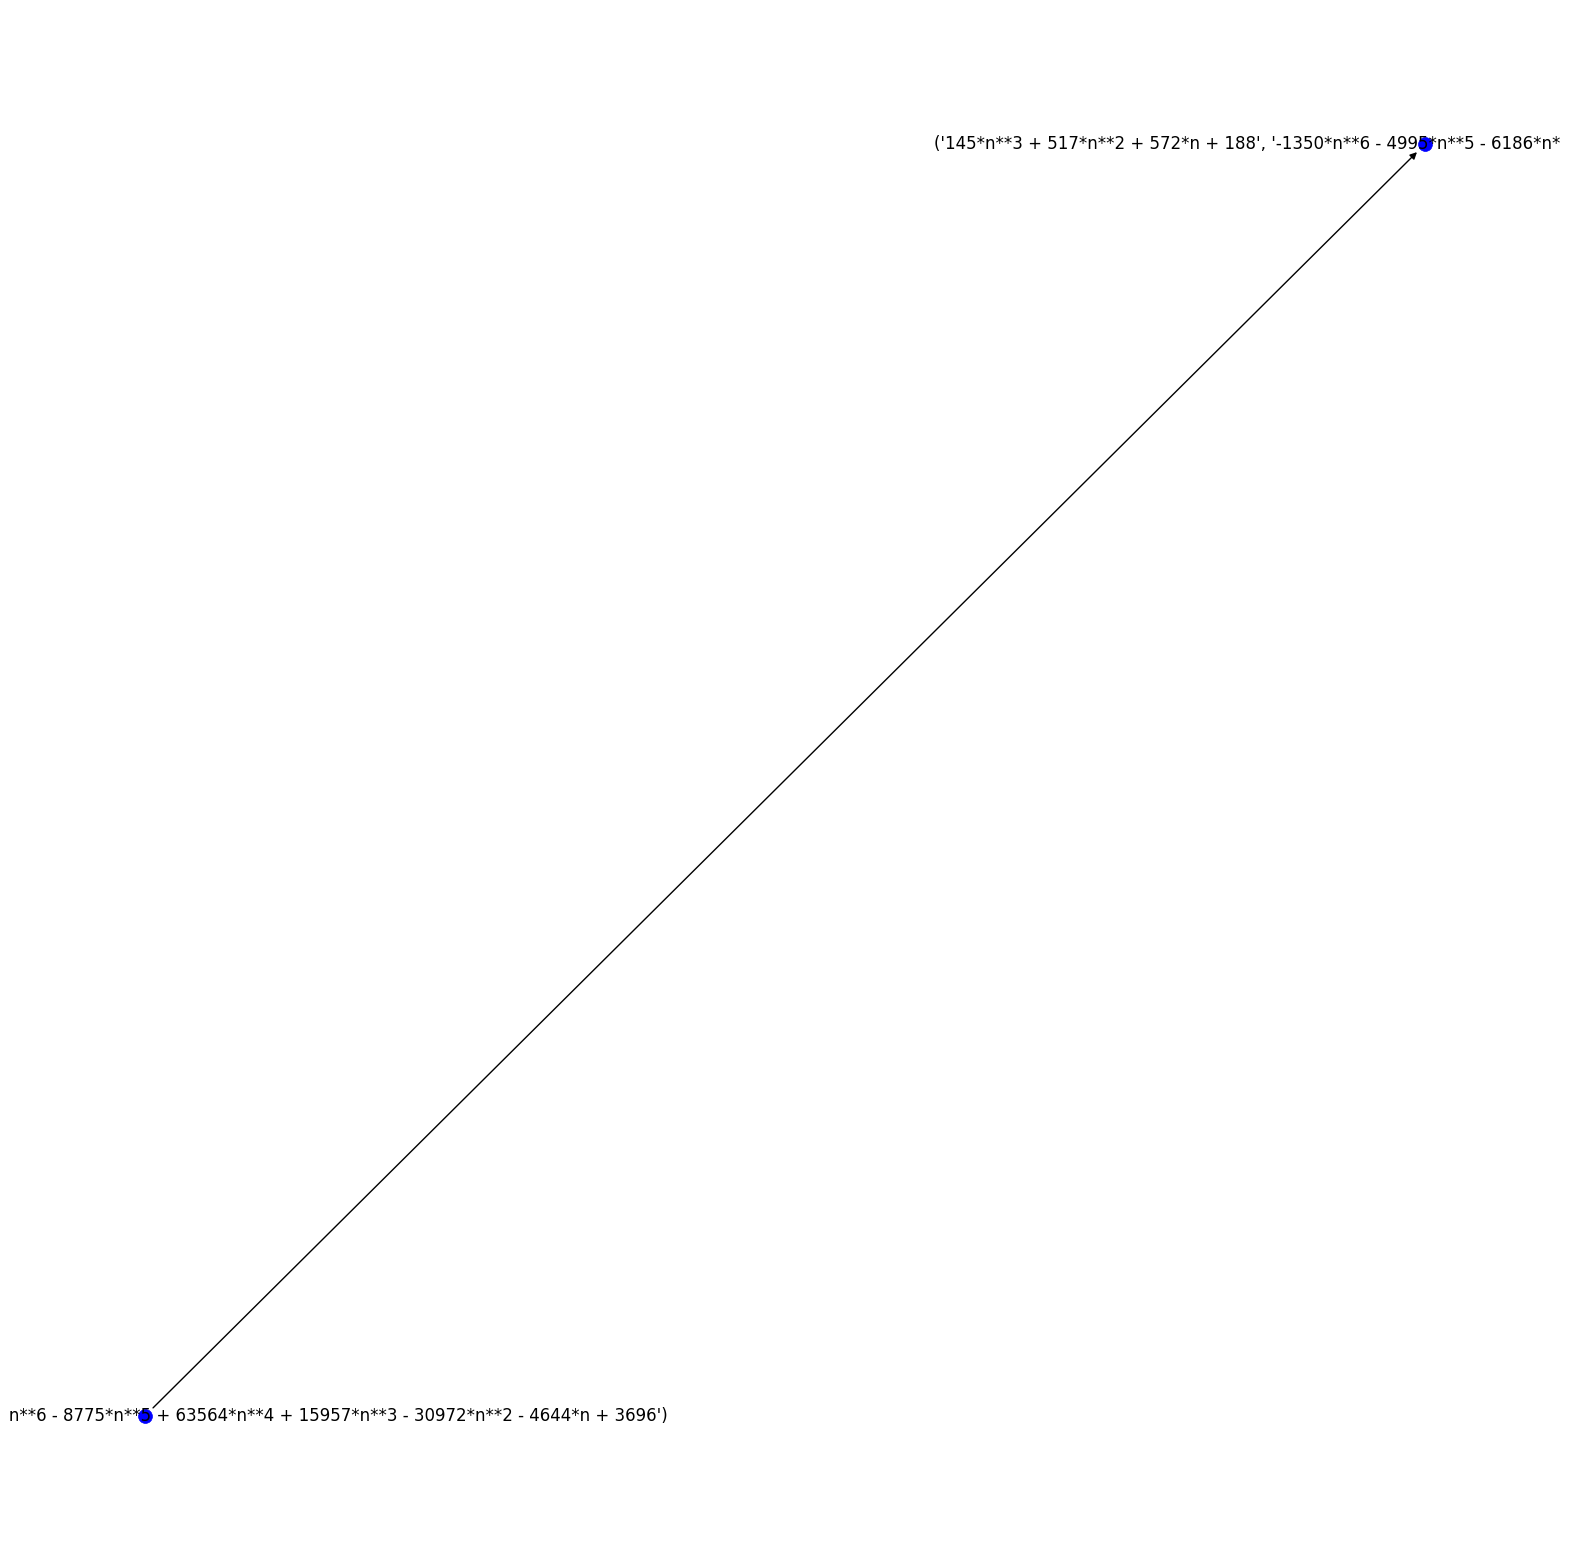

Subgraph with 2 nodes and 1 edges and 1 cc


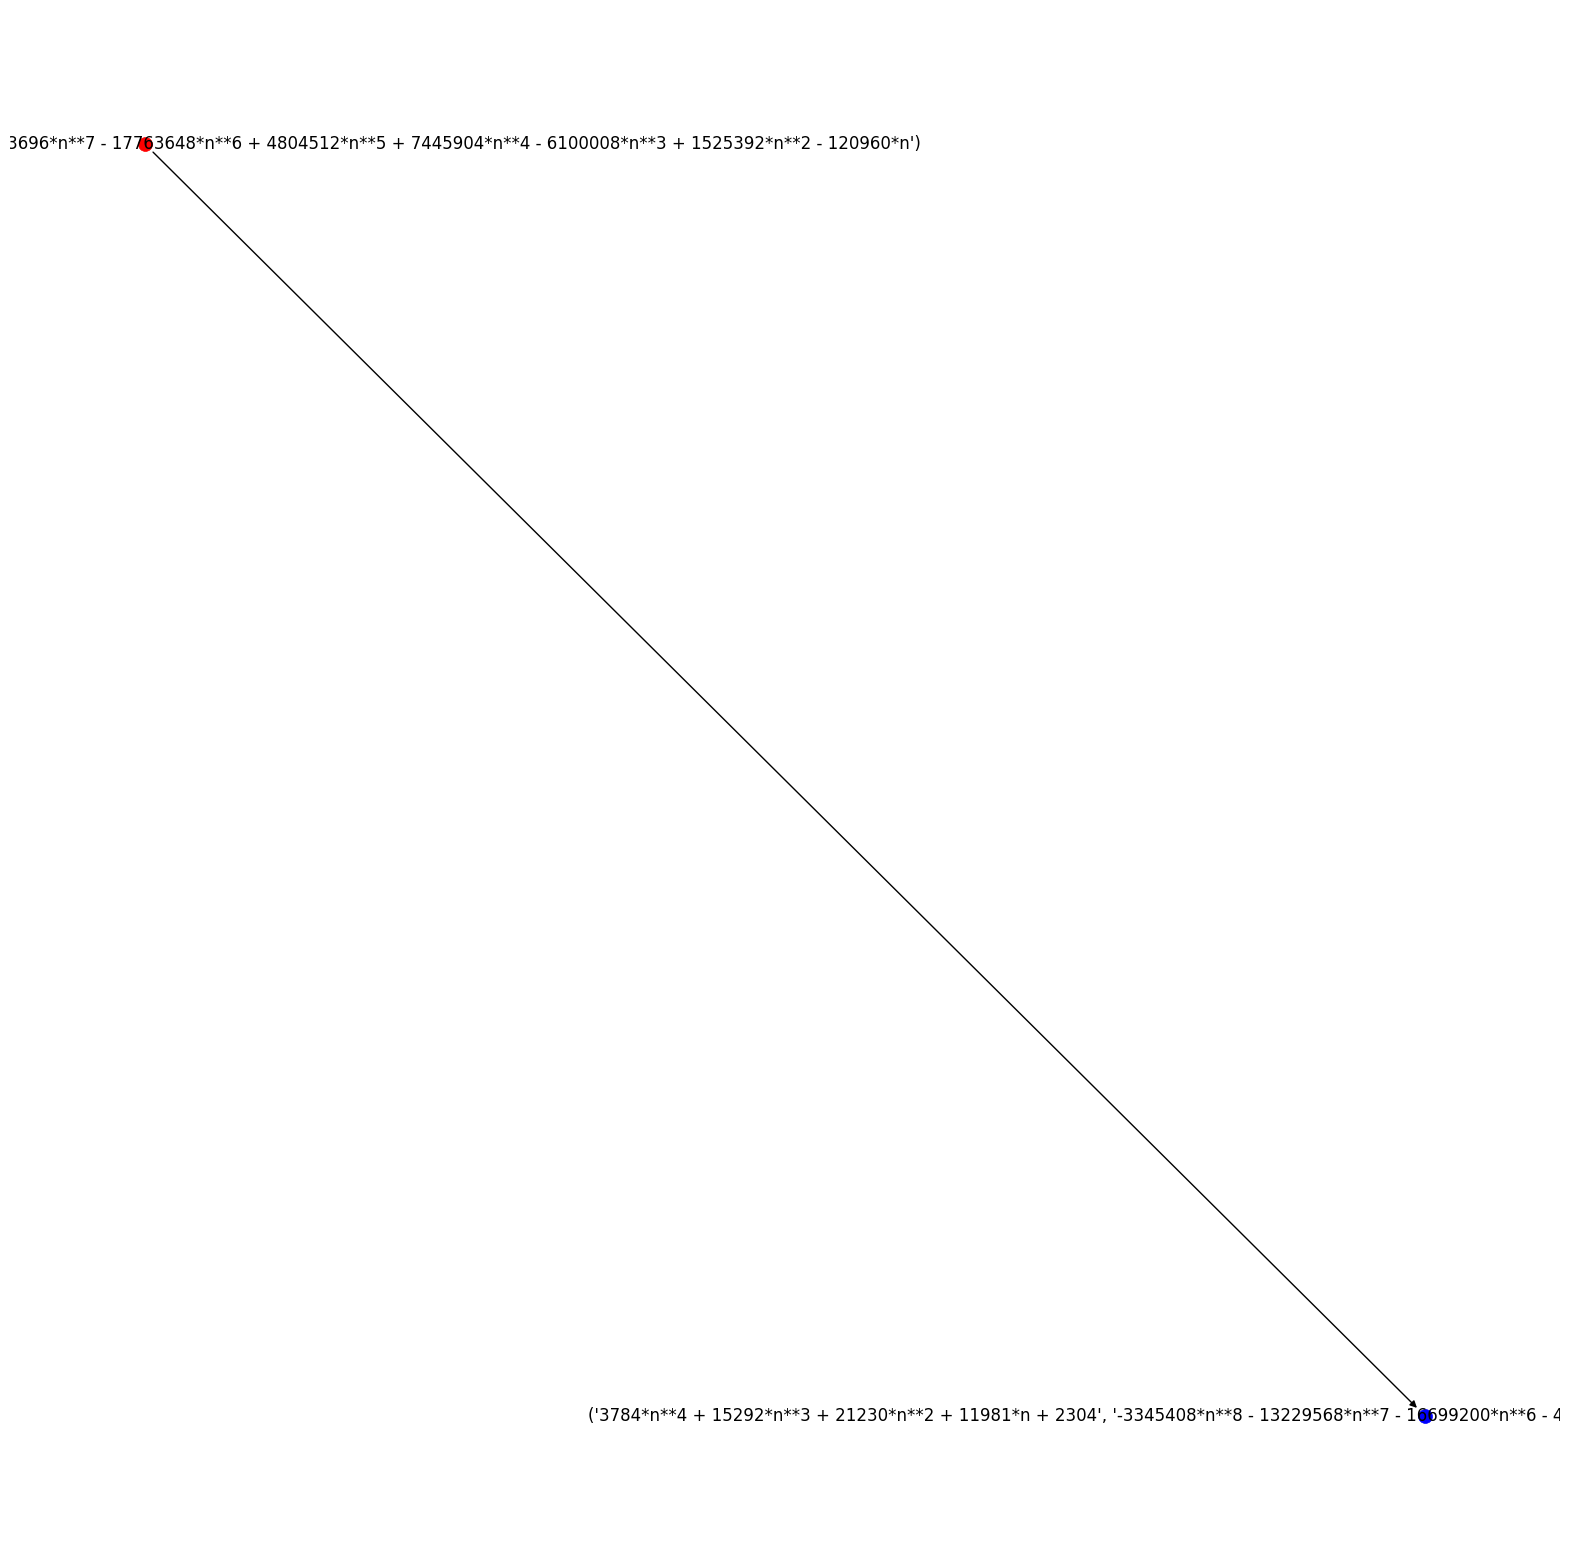

Subgraph with 2 nodes and 1 edges and 1 cc


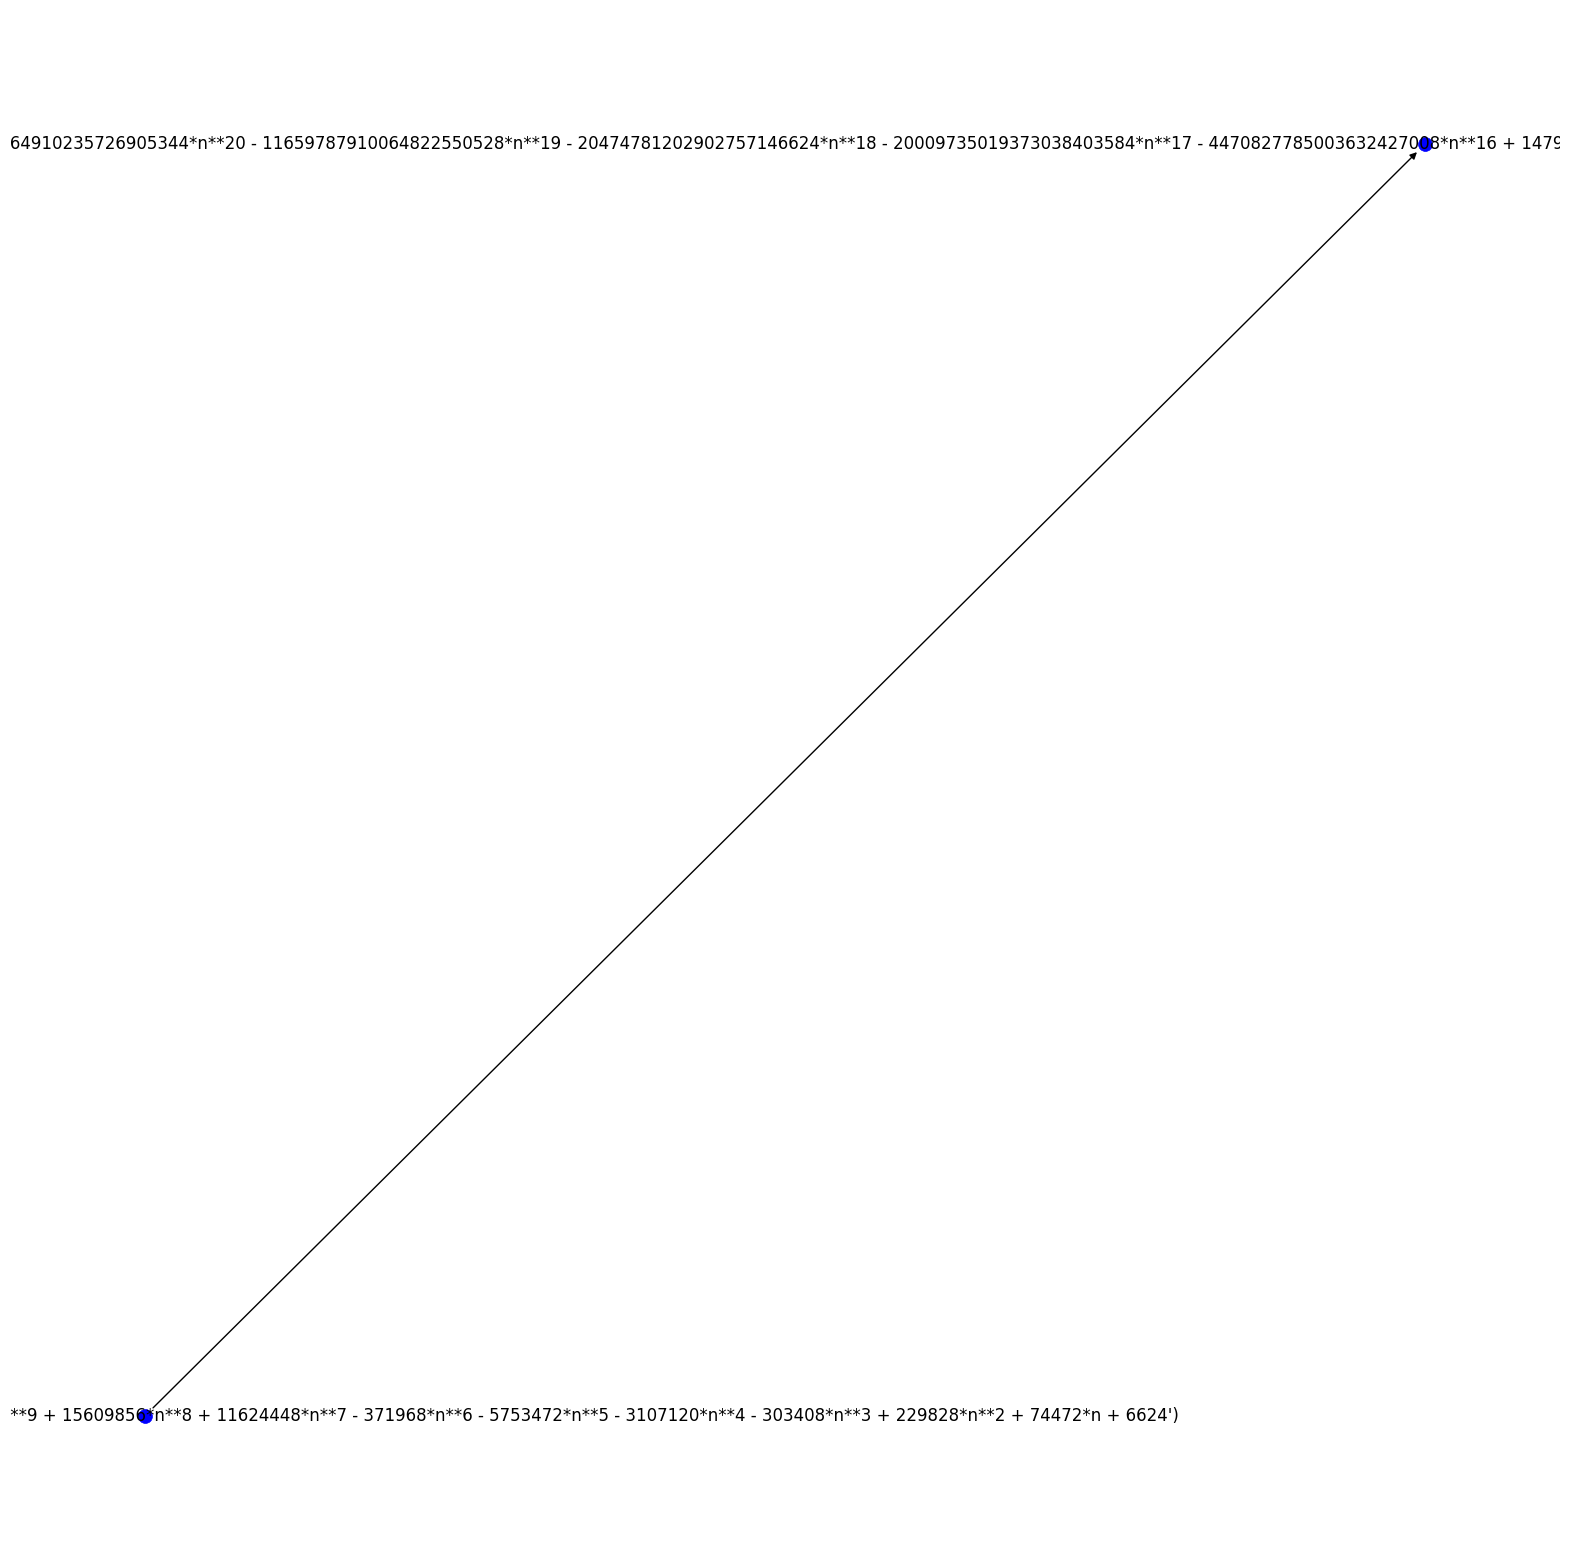

Subgraph with 2 nodes and 1 edges and 1 cc


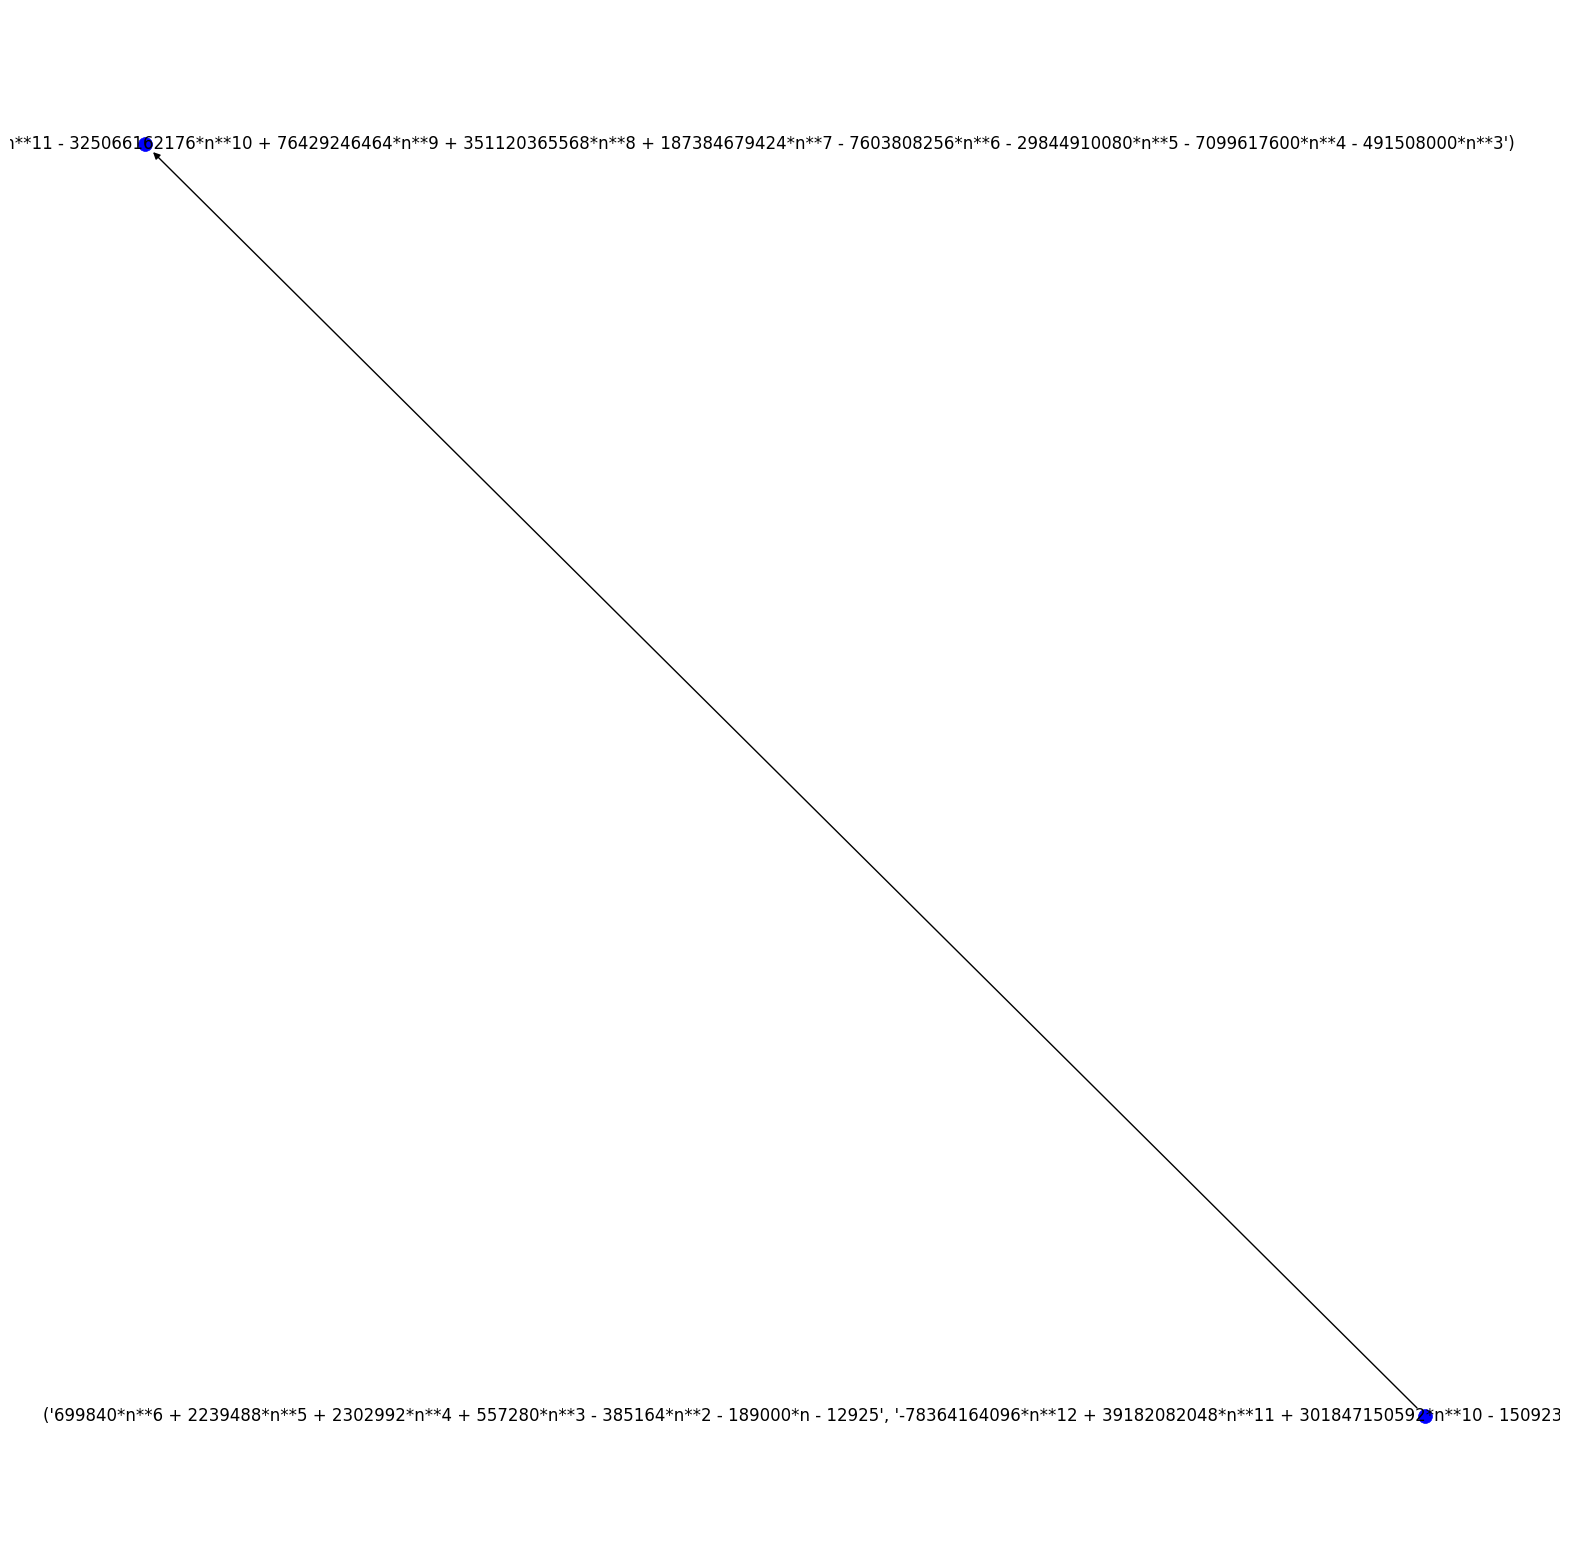

In [22]:
for subgraph in sorted(list(nx.weakly_connected_components(graph)), key=len, reverse=True):
    subgraph = graph.subgraph(subgraph)
    if len(subgraph.nodes) >= 2:
        
        print(f"Subgraph with {len(subgraph.nodes())} nodes and {len(subgraph.edges())} edges and {len(list(nx.weakly_connected_components(subgraph)))} cc")

        plt.figure(figsize=(20, 20))
        pos = nx.spring_layout(subgraph, k=1.5, iterations=100)

        # use red for nodes with 'cmf_sources' attribute but no 'sources' attribute
        # (i.e., CMF nodes)
        cmf_nodes = [node for node in subgraph.nodes if subgraph.nodes[node].get('cmf_sources', False)
                     and not subgraph.nodes[node].get('sources', False)]
        nx.draw_networkx_nodes(subgraph, pos, nodelist=cmf_nodes, node_color='red', node_size=100, linewidths=0.5)

        # use purple for nodes with 'cmf_sources' attribute and 'sources' attribute
        # (i.e., self-unifying nodes)
        self_unifying_nodes = [node for node in subgraph.nodes if subgraph.nodes[node].get('cmf_sources', False)
                              and subgraph.nodes[node].get('sources', False)]
        nx.draw_networkx_nodes(subgraph, pos, nodelist=self_unifying_nodes, node_color='purple', node_size=100, linewidths=0.5)

        # use blue for nodes without 'cmf_sources' attribute and with 'sources' attribute
        # (i.e., non-CMF, arXiv nodes)
        non_cmf_nodes_with_sources = [node for node in subgraph.nodes if not subgraph.nodes[node].get('cmf_sources', False)
                                      and subgraph.nodes[node].get('sources', False)]
        nx.draw_networkx_nodes(subgraph, pos, nodelist=non_cmf_nodes_with_sources, node_color='blue', node_size=100, linewidths=0.5)

        nx.draw_networkx_labels(subgraph, pos)
        edges_with_transformation = [
            (u, v) for u, v, d in subgraph.edges(data=True)
            if d.get('transformation') is not None
        ]
        nx.draw_networkx_edges(subgraph, pos, edgelist=edges_with_transformation)

        plt.axis('off')
        plt.show()